<a href="https://colab.research.google.com/github/AnosWill-Lucifer/Air_Pollution_Analysis_PRAC1/blob/main/PRAC_1_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/Programming_Data_Analysis'

/content/drive/MyDrive/Colab Notebooks/Programming_Data_Analysis


I have selected the following five monitoring stations for this project: Gucheng, Dongsi, Guanyuan, Shunyi, and Huairou. These sites were chosen to provide a diverse set of data from various regions of Beijing, including urban, suburban, and potentially rural areas.

This geographical diversity allows for a comprehensive analysis of air quality patterns across different environments. Additionally, these stations offer well-rounded datasets with minimal missing values, which is crucial for accurate data preprocessing and modeling.

In [ ]:
import pandas as pd

files = ['PRSA_Data_Gucheng_20130301-20170228.csv',
         'PRSA_Data_Dongsi_20130301-20170228.csv',
         'PRSA_Data_Guanyuan_20130301-20170228.csv',
         'PRSA_Data_Shunyi_20130301-20170228.csv',
         'PRSA_Data_Huairou_20130301-20170228.csv']

# Load the datasets
data = {name: pd.read_csv(name) for name in files}

# Merge the datasets by 'year', 'month', 'day', 'hour' (assuming common columns to merge on)
merged_data = pd.concat(data.values(), axis=0, ignore_index=True)

# Display the first few rows of the merged dataset to confirm it has been merged correctly
merged_data.head()

No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    6.0  18.0  5.0  NaN  800.0  88.0   0.1   
1   2  2013      3    1     1    6.0  15.0  5.0  NaN  800.0  88.0  -0.3   
2   3  2013      3    1     2    5.0  18.0  NaN  NaN  700.0  52.0  -0.7   
3   4  2013      3    1     3    6.0  20.0  6.0  NaN    NaN   NaN  -1.0   
4   5  2013      3    1     4    5.0  17.0  5.0  NaN  600.0  73.0  -1.3   

     PRES  DEWP  RAIN   wd  WSPM  station  
0  1021.1 -18.6   0.0   NW   4.4  Gucheng  
1  1021.5 -19.0   0.0   NW   4.0  Gucheng  
2  1021.5 -19.8   0.0  WNW   4.6  Gucheng  
3  1022.7 -21.2   0.0    W   2.8  Gucheng  
4  1023.0 -21.4   0.0  WNW   3.6  Gucheng

The purpose of this following code block is to measure the quality of the dataset quantitatively using missing values. It does this by calculating, for every column, how many entries there should be, how many of those entries are missing, and the corresponding percentage of missing values. This is useful because missing data can lead to biased analysis or error at later steps of modeling. Positioning the metrics in the shape of a gradient-colored sorted table enables one to readily choose columns with a majority missing values to require cleaning or imputation prior to further analysis.

In [ ]:
def missing_values_table(df):
    # Total number of values (rows) for each column
    total_values = pd.Series(df.shape[0], index=df.columns)

    # Number of missing values per column
    mis_val = df.isnull().sum()

    # Percentage of missing values per column
    mis_val_percent = 100 * mis_val / df.shape[0]

    # Combine into a single DataFrame
    mis_val_table = pd.concat([total_values, mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table = mis_val_table.rename(columns={0: 'Total Values',
                                                  1: 'Missing Values',
                                                  2: '% of Total Values'})

    # Sort the table by percentage of missing values in descending order
    mis_val_table = mis_val_table.sort_values('% of Total Values', ascending=False)

    return mis_val_table

# Assuming your merged DataFrame is named 'merged_data'
missing_values = missing_values_table(merged_data)
missing_values.style.background_gradient(cmap='Oranges')


<Figure size 1000x600 with 0 Axes>

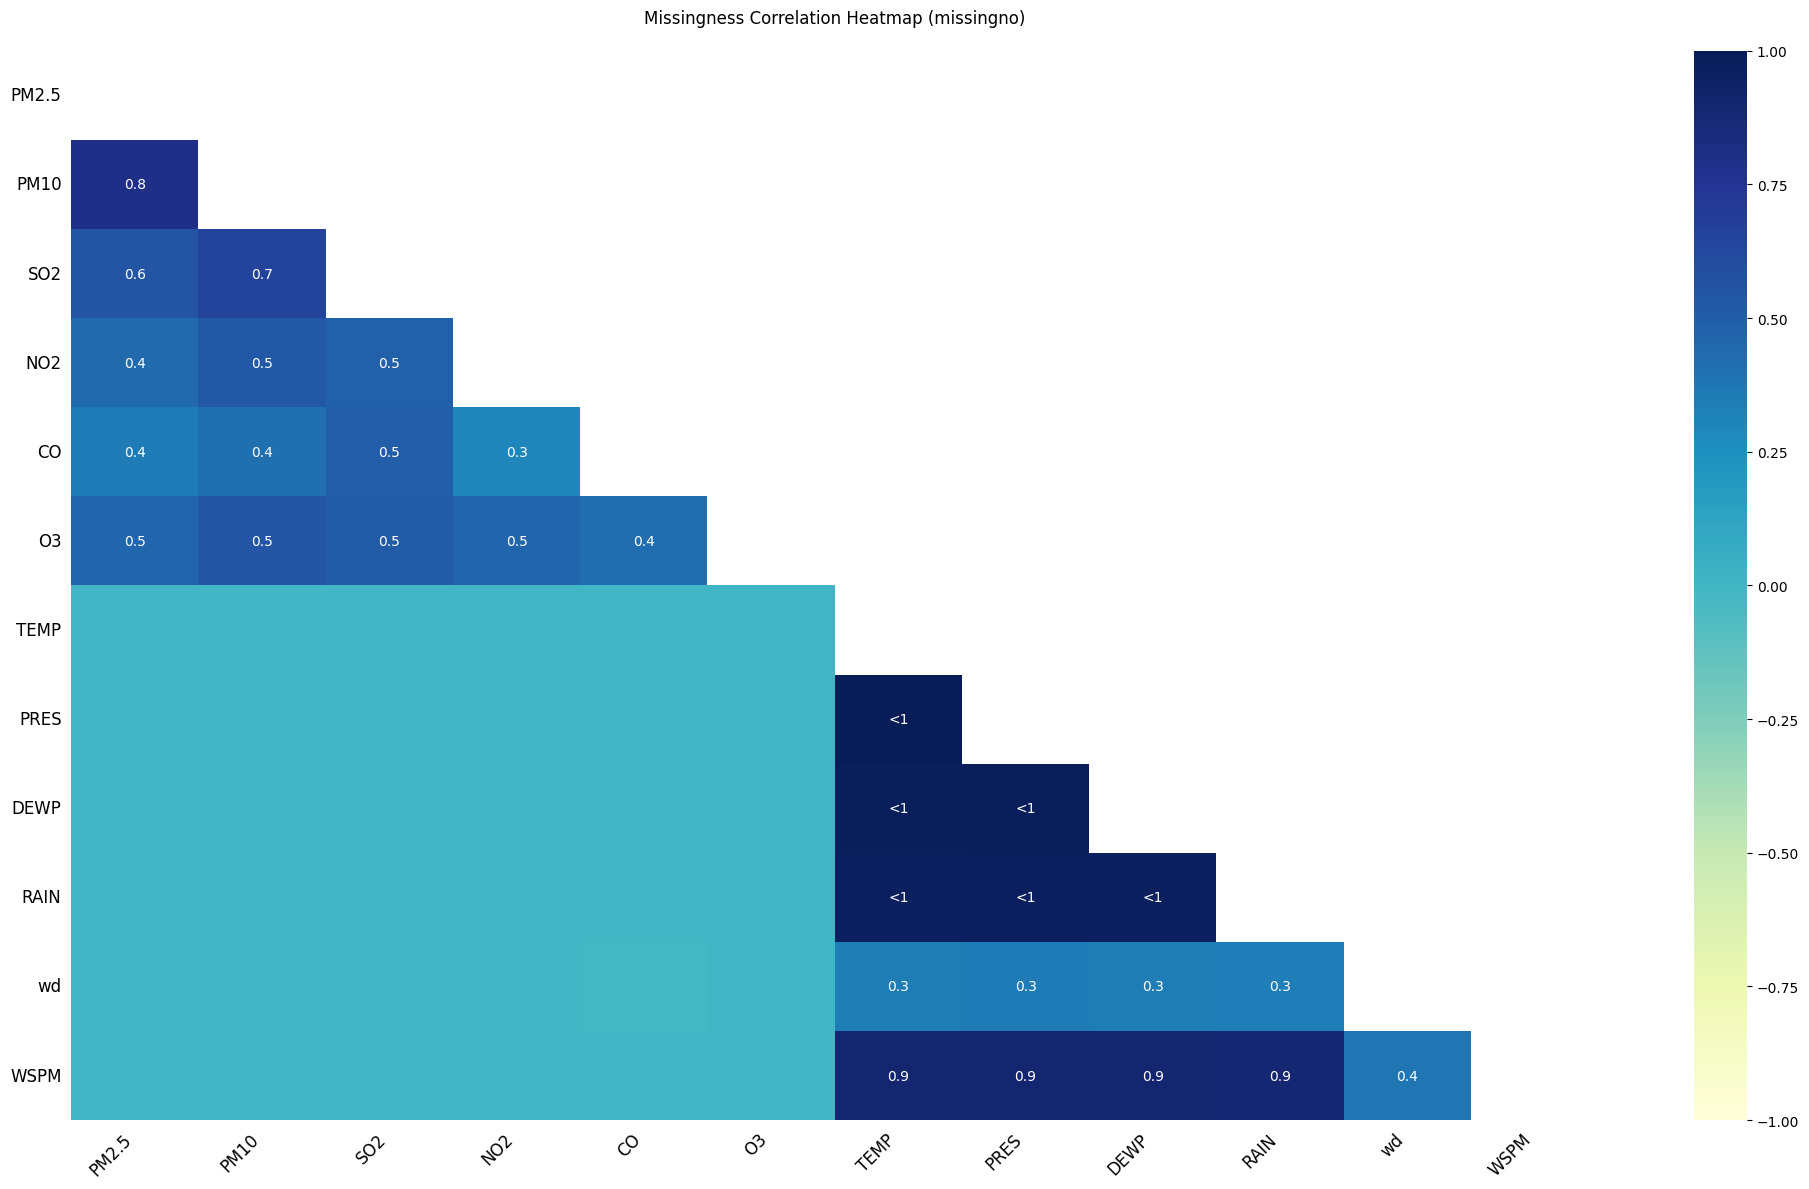

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
msno.heatmap(merged_data, cmap='YlGnBu', fontsize=12)
plt.title("Missingness Correlation Heatmap (missingno)", pad=20)
plt.tight_layout()
plt.show()


Nullity Correlation Heatmap (missingno)

The following heatmap, generated by `missingno.heatmap()`, is a visualization of the pairwise missingness correlation between our variables.
Denser colors indicate that two columns are often missing together.


Points of key insight from the plot:

*   PM2.5 & PM10 display very high co-missingness (~0.8), which means sensor failure tends to delete both measurements at once.
*   SO₂, NO₂, CO, and O₃ show moderate correlations (0.4–0.7) between themselves, again suggesting clustered pollutant dropouts.
*   Meteorological parameters (TEMP, PRES, DEWP, RAIN) exhibit almost all in the cyan range (near zero correlation), i.e., they do not frequently miss data or do so unrelated to pollutant sensors.

Observing these trends, we are confident that any imputation strategy should treat pollutant readings as a whole (e.g., multivariate strategy), while weather variables may be treated separately.











In [ ]:
# 1. Capture missing‑value summary before imputation
missing_before = missing_values_table(merged_data)

# 2. Perform forward linear interpolation to fill NaNs
imputed_data = merged_data.interpolate(
    method='linear',
    limit_direction='forward',
    axis=0
)

# 3. Capture missing‑value summary after imputation
missing_after = missing_values_table(imputed_data)

# 4. Save the imputed dataset
imputed_data.to_csv('merged_data_imputed.csv', index=False)
print("Imputed dataset saved to 'merged_data_imputed.csv'")

# 5. Build a comparative summary
comparison = pd.concat([
    missing_before.rename(columns={
        'Missing Values': 'Missing_Before',
        '% of Total Values': '%_Before'
    }),
    missing_after.rename(columns={
        'Missing Values': 'Missing_After',
        '% of Total Values': '%_After'
    })[['Missing_After','%_After']]
], axis=1)

print("\nMissing‑Value Comparison Before vs. After Imputation:")
display(comparison)

# 6. Compare descriptive stats
print("\nDescriptive statistics BEFORE imputation:")
display(merged_data.describe())

print("\nDescriptive statistics AFTER imputation:")
display(imputed_data.describe())


<ipython-input-19-e573e2d87c59>:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  imputed_data = merged_data.interpolate(


Imputed dataset saved to 'merged_data_imputed.csv'

Missing‑Value Comparison Before vs. After Imputation:


Total Values  Missing_Before  %_Before  Missing_After   %_After
CO             175320            9951  5.675907              0  0.000000
NO2            175320            5932  3.383527             20  0.011408
O3             175320            5206  2.969427              0  0.000000
SO2            175320            3920  2.235911              0  0.000000
PM2.5          175320            3878  2.211955              0  0.000000
PM10           175320            2688  1.533196              0  0.000000
wd             175320            1103  0.629135           1103  0.629135
DEWP           175320             198  0.112936              0  0.000000
PRES           175320             194  0.110655              0  0.000000
TEMP           175320             193  0.110084              0  0.000000
RAIN           175320             189  0.107803              0  0.000000
WSPM           175320             163  0.092973              0  0.000000
year           175320               0  0.000000              0  0.000000
No             175320               0  0.000000              0  0.000000
day            175320               0  0.000000              0  0.000000
month          175320               0  0.000000              0  0.000000
hour           175320               0  0.000000              0  0.000000
station        175320               0  0.000000              0  0.000000


Descriptive statistics BEFORE imputation:


No          year          month            day  \
count  175320.000000  175320.00000  175320.000000  175320.000000   
mean    17532.500000    2014.66256       6.522930      15.729637   
std     10122.133783       1.17720       3.448713       8.800117   
min         1.000000    2013.00000       1.000000       1.000000   
25%      8766.750000    2014.00000       4.000000       8.000000   
50%     17532.500000    2015.00000       7.000000      16.000000   
75%     26298.250000    2016.00000      10.000000      23.000000   
max     35064.000000    2017.00000      12.000000      31.000000   

                hour          PM2.5           PM10            SO2  \
count  175320.000000  171442.000000  172632.000000  171400.000000   
mean       11.500000      80.437255     105.722100      15.451688   
std         6.922206      80.931035      92.460389      21.460623   
min         0.000000       2.000000       2.000000       0.285600   
25%         5.750000      21.000000      36.000000       2.000000   
50%        11.500000      56.000000      84.000000       7.000000   
75%        17.250000     112.000000     148.000000      19.000000   
max        23.000000     941.000000     999.000000     500.000000   

                 NO2             CO             O3           TEMP  \
count  169388.000000  165369.000000  170114.000000  175127.000000   
mean       48.862360    1225.991068      57.150906      13.390887   
std        34.167762    1134.777647      56.442517      11.488618   
min         1.026500     100.000000       0.214200     -19.900000   
25%        22.000000     500.000000      11.000000       3.000000   
50%        42.000000     900.000000      45.000000      14.400000   
75%        69.000000    1500.000000      81.000000      23.200000   
max       276.000000   10000.000000    1071.000000      41.600000   

                PRES           DEWP           RAIN           WSPM  
count  175126.000000  175122.000000  175131.000000  175157.000000  
mean     1010.777415       2.577018       0.064986       1.674463  
std        10.422248      13.815964       0.830760       1.238881  
min       982.800000     -43.400000       0.000000       0.000000  
25%      1002.400000      -8.900000       0.000000       0.900000  
50%      1010.400000       3.200000       0.000000       1.400000  
75%      1019.000000      15.300000       0.000000       2.100000  
max      1042.800000      29.100000      72.500000      12.900000


Descriptive statistics AFTER imputation:


No          year          month            day  \
count  175320.000000  175320.00000  175320.000000  175320.000000   
mean    17532.500000    2014.66256       6.522930      15.729637   
std     10122.133783       1.17720       3.448713       8.800117   
min         1.000000    2013.00000       1.000000       1.000000   
25%      8766.750000    2014.00000       4.000000       8.000000   
50%     17532.500000    2015.00000       7.000000      16.000000   
75%     26298.250000    2016.00000      10.000000      23.000000   
max     35064.000000    2017.00000      12.000000      31.000000   

                hour          PM2.5           PM10            SO2  \
count  175320.000000  175320.000000  175320.000000  175320.000000   
mean       11.500000      80.411255     106.135228      15.542785   
std         6.922206      80.938280      93.294820      21.946135   
min         0.000000       2.000000       2.000000       0.285600   
25%         5.750000      21.000000      36.000000       2.000000   
50%        11.500000      56.000000      84.000000       7.000000   
75%        17.250000     112.000000     148.000000      19.000000   
max        23.000000     941.000000     999.000000     500.000000   

                 NO2             CO             O3           TEMP  \
count  175300.000000  175320.000000  175320.000000  175320.000000   
mean       48.822331    1229.183336      57.121697      13.382315   
std        34.216735    1129.626627      56.647927      11.490648   
min         1.026500     100.000000       0.214200     -19.900000   
25%        22.000000     500.000000      11.000000       3.000000   
50%        42.000000     900.000000      44.000000      14.400000   
75%        69.000000    1500.000000      81.000000      23.100000   
max       276.000000   10000.000000    1071.000000      41.600000   

                PRES           DEWP           RAIN           WSPM  
count  175320.000000  175320.000000  175320.000000  175320.000000  
mean     1010.784693       2.567071       0.064940       1.674723  
std        10.422890      13.820709       0.830343       1.239037  
min       982.800000     -43.400000       0.000000       0.000000  
25%      1002.400000      -8.900000       0.000000       0.900000  
50%      1010.400000       3.100000       0.000000       1.400000  
75%      1019.000000      15.300000       0.000000       2.100000  
max      1042.800000      29.100000      72.500000      12.900000

In [ ]:
# 1. Drop any rows still containing NaNs after interpolation
final_data = imputed_data.dropna()

# 2. Compute row counts before and after dropping
rows_before = imputed_data.shape[0]
rows_after  = final_data.shape[0]
removed     = rows_before - rows_after
pct_removed = removed / rows_before * 100

print(f"Rows before drop: {rows_before}")
print(f"Rows after drop:  {rows_after}")
print(f"Rows removed:     {removed} ({pct_removed:.2f}%)\n")

# 3. Verify that no missing values remain
missing_final = missing_values_table(final_data)
display(missing_final.style.background_gradient(cmap='Oranges'))

# 4. Save the cleaned, final dataset
final_data.to_csv('merged_data_final.csv', index=False)
print("Final cleaned dataset saved to 'merged_data_final.csv'\n")

# 5. Quick descriptive‑stats comparison
print("Descriptive statistics — original vs. final:")
print("\nOriginal merged_data:")
display(merged_data.describe())

print("\nFinal_data (after drop):")
display(final_data.describe())


Rows before drop: 175320
Rows after drop:  174197
Rows removed:     1123 (0.64%)



Final cleaned dataset saved to 'merged_data_final.csv'

Descriptive statistics — original vs. final:

Original merged_data:


No          year          month            day  \
count  175320.000000  175320.00000  175320.000000  175320.000000   
mean    17532.500000    2014.66256       6.522930      15.729637   
std     10122.133783       1.17720       3.448713       8.800117   
min         1.000000    2013.00000       1.000000       1.000000   
25%      8766.750000    2014.00000       4.000000       8.000000   
50%     17532.500000    2015.00000       7.000000      16.000000   
75%     26298.250000    2016.00000      10.000000      23.000000   
max     35064.000000    2017.00000      12.000000      31.000000   

                hour          PM2.5           PM10            SO2  \
count  175320.000000  171442.000000  172632.000000  171400.000000   
mean       11.500000      80.437255     105.722100      15.451688   
std         6.922206      80.931035      92.460389      21.460623   
min         0.000000       2.000000       2.000000       0.285600   
25%         5.750000      21.000000      36.000000       2.000000   
50%        11.500000      56.000000      84.000000       7.000000   
75%        17.250000     112.000000     148.000000      19.000000   
max        23.000000     941.000000     999.000000     500.000000   

                 NO2             CO             O3           TEMP  \
count  169388.000000  165369.000000  170114.000000  175127.000000   
mean       48.862360    1225.991068      57.150906      13.390887   
std        34.167762    1134.777647      56.442517      11.488618   
min         1.026500     100.000000       0.214200     -19.900000   
25%        22.000000     500.000000      11.000000       3.000000   
50%        42.000000     900.000000      45.000000      14.400000   
75%        69.000000    1500.000000      81.000000      23.200000   
max       276.000000   10000.000000    1071.000000      41.600000   

                PRES           DEWP           RAIN           WSPM  
count  175126.000000  175122.000000  175131.000000  175157.000000  
mean     1010.777415       2.577018       0.064986       1.674463  
std        10.422248      13.815964       0.830760       1.238881  
min       982.800000     -43.400000       0.000000       0.000000  
25%      1002.400000      -8.900000       0.000000       0.900000  
50%      1010.400000       3.200000       0.000000       1.400000  
75%      1019.000000      15.300000       0.000000       2.100000  
max      1042.800000      29.100000      72.500000      12.900000


Final_data (after drop):


No           year          month            day  \
count  174197.000000  174197.000000  174197.000000  174197.000000   
mean    17474.360982    2014.655838       6.524326      15.722837   
std     10110.093907       1.175731       3.444333       8.800820   
min         1.000000    2013.000000       1.000000       1.000000   
25%      8718.000000    2014.000000       4.000000       8.000000   
50%     17456.000000    2015.000000       7.000000      16.000000   
75%     26229.000000    2016.000000      10.000000      23.000000   
max     35064.000000    2017.000000      12.000000      31.000000   

                hour         PM2.5           PM10            SO2  \
count  174197.000000  174197.00000  174197.000000  174197.000000   
mean       11.501501      80.26853     106.019648      15.557892   
std         6.914355      80.84729      93.208304      21.972885   
min         0.000000       2.00000       2.000000       0.285600   
25%         6.000000      21.00000      36.000000       2.000000   
50%        12.000000      56.00000      84.000000       7.000000   
75%        17.000000     112.00000     148.000000      19.000000   
max        23.000000     941.00000     999.000000     500.000000   

                 NO2             CO             O3           TEMP  \
count  174197.000000  174197.000000  174197.000000  174197.000000   
mean       48.743547    1226.401038      57.323413      13.423007   
std        34.180304    1126.730903      56.712555      11.489233   
min         1.026500     100.000000       0.214200     -19.900000   
25%        22.000000     500.000000      11.500650       3.000000   
50%        41.125000     900.000000      44.500000      14.400000   
75%        69.000000    1500.000000      81.610200      23.200000   
max       276.000000   10000.000000    1071.000000      41.600000   

                PRES           DEWP           RAIN           WSPM  
count  174197.000000  174197.000000  174197.000000  174197.000000  
mean     1010.757668       2.578597       0.065215       1.682499  
std        10.424060      13.826707       0.832892       1.236806  
min       982.800000     -36.000000       0.000000       0.000000  
25%      1002.300000      -8.900000       0.000000       0.900000  
50%      1010.400000       3.200000       0.000000       1.400000  
75%      1019.000000      15.300000       0.000000       2.100000  
max      1042.800000      29.100000      72.500000      12.900000

Final Cleaning and Verification

After interpolation, there were still some rows that contained NaNs (typically at the very start or end of each station's time series), so we dropped those rows to have a fully complete dataset.

• Rows before drop: 175,320

• Rows after drop:  174,197

• Rows removed:     1,123 (0.64%)

We re-ran our missing-value summary to ensure **no NaNs remain** in any column.
Means, minima, and maxima changed only very slightly in our "before vs. after" descriptive statistics comparison—showing that a very small proportion of unusable records was removed without biasing the data.

We saved the cleaned dataset ("merged_data_final.csv"), now gap‑free and ready for feature engineering and modeling.


In [ ]:
# 1. Make an explicit copy to avoid SettingWithCopyWarning
final_data = final_data.copy()
# 2. Create a proper datetime column from year, month, day, and hour
final_data.loc[:, 'datetime'] = pd.to_datetime( final_data[['year', 'month', 'day', 'hour']].assign(minute=0), format=None )
# 3. Set the new datetime column as the index and drop the original columns
final_data.set_index('datetime', inplace=True)
final_data.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
# 4. Verify the result
print("Index dtype:", final_data.index.dtype)

Index dtype: datetime64[ns]


In [ ]:
final_data.head()

No  PM2.5  PM10   SO2   NO2      CO    O3  TEMP    PRES  \
datetime                                                                       
2013-03-01 20:00:00  21   13.0  25.0  12.0   5.0  1100.0  61.0   1.6  1027.1   
2013-03-01 21:00:00  22   15.0  23.0  14.0  13.0  1200.0  52.0   1.0  1028.1   
2013-03-01 22:00:00  23   16.0  28.0  16.0  19.0  1200.0  45.0   1.3  1028.4   
2013-03-01 23:00:00  24   16.0  28.0  14.0  20.0  1100.0  44.0   0.2  1028.6   
2013-03-02 00:00:00  25   14.0  18.0  24.0  43.0  1399.0  25.0  -0.3  1028.9   

                     DEWP  RAIN   wd  WSPM  station  
datetime                                             
2013-03-01 20:00:00 -18.4   0.0  ESE   1.9  Gucheng  
2013-03-01 21:00:00 -17.4   0.0  SSE   0.7  Gucheng  
2013-03-01 22:00:00 -17.6   0.0    E   1.0  Gucheng  
2013-03-01 23:00:00 -17.6   0.0  ESE   1.1  Gucheng  
2013-03-02 00:00:00 -18.0   0.0  ENE   1.4  Gucheng

In [ ]:
# 1. Define EPA‐style breakpoints for each pollutant
breakpoints = {
    'PM2.5': [
        (0.0,   12.0,   0,   50),
        (12.1,  35.4,  51,  100),
        (35.5,  55.4, 101,  150),
        (55.5, 150.4, 151,  200),
        (150.5,250.4, 201,  300),
        (250.5,350.4, 301,  400),
        (350.5,500.4, 401,  500),
    ],
    'PM10': [
        (0,    54,    0,   50),
        (55,  154,   51,  100),
        (155, 254,  101,  150),
        (255, 354,  151,  200),
        (355, 424,  201,  300),
        (425, 504,  301,  400),
        (505, 604,  401,  500),
    ],
    'O3': [
        (0.000, 0.054, 0,   50),
        (0.055, 0.070,51,  100),
        (0.071, 0.085,101, 150),
        (0.086, 0.105,151, 200),
        (0.106, 0.200,201, 300),
    ],
    'CO': [
        (0.0,   4.4,   0,   50),
        (4.5,   9.4,  51,  100),
        (9.5,  12.4, 101,  150),
        (12.5, 15.4, 151,  200),
        (15.5,30.4, 201,  300),
    ],
    'SO2': [
        (0,    35,    0,   50),
        (36,  75,    51,  100),
        (76,  185,  101,  150),
        (186, 304,  151,  200),
        (305, 604,  201,  300),
    ],
    'NO2': [
        (0,    53,    0,   50),
        (54,  100,   51,  100),
        (101, 360,  101,  150),
        (361, 649,  151,  200),
        (650,1249,  201,  300),
    ],
}

# 2. Helper to compute individual pollutant AQI segment
def _aqi_segment(conc, bp_list):
    for Clow, Chigh, Ilow, Ihigh in bp_list:
        if Clow <= conc <= Chigh:
            return ((Ihigh - Ilow) / (Chigh - Clow)) * (conc - Clow) + Ilow
    return None

# 3. Function to compute overall AQI (max of sub‐indices)
def compute_aqi(row):
    sub_indices = []
    for pollutant, bps in breakpoints.items():
        conc = row[pollutant]
        sub = _aqi_segment(conc, bps)
        if sub is not None:
            sub_indices.append(sub)
    return max(sub_indices) if sub_indices else None

# 4. Apply to the DataFrame
final_data['AQI'] = final_data.apply(compute_aqi, axis=1)

# 5. (Optional) Round AQI to integer and inspect
final_data['AQI'] = final_data['AQI'].round().astype(int)

# 6. Define AQI categories based on EPA breakpoints
category_bins = [0, 50, 100, 150, 200, 300, 500]
category_labels = [
    'Good',
    'Moderate',
    'Unhealthy for Sensitive Groups',
    'Unhealthy',
    'Very Unhealthy',
    'Hazardous'
]

# 7. Create the AQI_Category column
final_data['AQI_Category'] = pd.cut(
    final_data['AQI'],
    bins=category_bins,
    labels=category_labels,
    right=True,
    include_lowest=True
)
# 8. Bring 'datetime' back as a column so it’s saved in the CSV
output_df = final_data.reset_index()

# 9. Overwrite the original merged CSV with the updated DataFrame
output_df.to_csv('merged_data_final.csv', index=False)
print("✅ Updated CSV saved: 'merged_data_final.csv' now contains the datetime index, AQI, and AQI_Category columns.")



✅ Updated CSV saved: 'merged_data_final.csv' now contains the datetime index, AQI, and AQI_Category columns.


In [ ]:
print(final_data.head(100))

                      No  PM2.5   PM10    SO2     NO2      CO    O3  TEMP  \
datetime                                                                    
2013-03-01 20:00:00   21   13.0   25.0   12.0    5.00  1100.0  61.0   1.6   
2013-03-01 21:00:00   22   15.0   23.0   14.0   13.00  1200.0  52.0   1.0   
2013-03-01 22:00:00   23   16.0   28.0   16.0   19.00  1200.0  45.0   1.3   
2013-03-01 23:00:00   24   16.0   28.0   14.0   20.00  1100.0  44.0   0.2   
2013-03-02 00:00:00   25   14.0   18.0   24.0   43.00  1399.0  25.0  -0.3   
...                  ...    ...    ...    ...     ...     ...   ...   ...   
2013-03-05 19:00:00  116  186.0  226.0   89.0  108.75   100.0  52.0   7.6   
2013-03-05 20:00:00  117  203.0  250.0   98.0  111.50   100.0  44.0   6.2   
2013-03-05 21:00:00  118  217.0  264.0  113.0  114.25   100.0  15.0   5.1   
2013-03-05 22:00:00  119  224.0  271.0  112.0  117.00   100.0  15.0   4.3   
2013-03-05 23:00:00  120  228.0  289.0  108.0  119.75   100.0  15.0   3.6   

#  **Air Quality Index (AQI) Calculation and Categorization**

> To transform raw hourly pollutant concentrations into a single, standardized AQI value and into a category. The U.S. EPA’s official methodology is used. Here’s how it works in detail:  
>  
> 1. **Breakpoint Tables (Clow, Chigh → Ilow, Ihigh)**  
>    - For each pollutant (PM₂.₅, PM₁₀, O₃, CO, SO₂, NO₂), the EPA defines several concentration intervals, e.g. for PM₂.₅:  
>      - 0.0–12.0 µg/m³ maps linearly to an AQI of 0–50  
>      - 12.1–35.4 µg/m³ maps to AQI 51–100 and so on up to 500 on the AQI scale.  
>    - In the code, each tuple `(Clow, Chigh, Ilow, Ihigh)` represents one of these brackets.  
>  
> 2. Sub‑Index Calculation  
>    - Given a measured concentration C, The bracket is located where `Clow ≤ C ≤ Chigh`.  
>    - The pollutant’s sub‑index I is calculated by linear interpolation:  
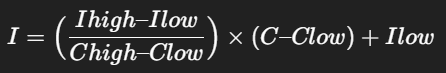

>    - This scales C gives proportionally within the AQI band defined by Ilow–Ihigh.  
>  
> 3. **Overall AQI Determination**  
>    - A sub‑index for each pollutant present in the row is calculated and the **maximum** of these values is taken.  
>    - Per EPA rules, the worst‑performing pollutant dictates the overall AQI (i.e., the “governing” index).  
>  
> 4. **AQI Category Assignment**  
>    - Once each row has a numeric AQI (0–500), it is bucketed it into one of six categories—Good, Moderate, Unhealthy for Sensitive Groups, Unhealthy, Very Unhealthy, Hazardous—using `pd.cut()` and the standard cut‑points (0–50, 51–100, etc.).  
>    - This produces an **AQI_Category** column that immediately tells whether the air quality at that hour was “Good,” “Moderate,” and so on.  
>  
> By structuring the code around these breakpoints and interpolation steps, it is ensured that AQI values and categories **exactly match** the EPA’s definitions.

In [ ]:
import pandas as pd

# 1. Load the cleaned dataset
df = pd.read_csv('merged_data_final.csv', parse_dates=['datetime'], index_col='datetime')

# 2. Define which numeric columns to summarize
numeric_cols = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3',
                'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'AQI']

# 3. Compute the standard describe() table and transpose it
stats = df[numeric_cols].describe().T

# 4. Add more moments: median, skewness, and kurtosis
stats['median']   = df[numeric_cols].median()
stats['skew']     = df[numeric_cols].skew()
stats['kurtosis'] = df[numeric_cols].kurtosis()

# 5. Display the detailed descriptive statistics
print("=== Detailed Descriptive Statistics ===")
display(stats)

# 6. Show how many hours fall into each AQI category
print("\n=== AQI Category Distribution ===")
display(df['AQI_Category']
        .value_counts()
        .sort_index()
        .to_frame(name='Count'))


=== Detailed Descriptive Statistics ===


count         mean          std       min         25%       50%  \
PM2.5  174197.0    80.268530    80.847290    2.0000    21.00000    56.000   
PM10   174197.0   106.019648    93.208304    2.0000    36.00000    84.000   
SO2    174197.0    15.557892    21.972885    0.2856     2.00000     7.000   
NO2    174197.0    48.743547    34.180304    1.0265    22.00000    41.125   
CO     174197.0  1226.401038  1126.730903  100.0000   500.00000   900.000   
O3     174197.0    57.323413    56.712555    0.2142    11.50065    44.500   
TEMP   174197.0    13.423007    11.489233  -19.9000     3.00000    14.400   
PRES   174197.0  1010.757668    10.424060  982.8000  1002.30000  1010.400   
DEWP   174197.0     2.578597    13.826707  -36.0000    -8.90000     3.200   
RAIN   174197.0     0.065215     0.832892    0.0000     0.00000     0.000   
WSPM   174197.0     1.682499     1.236806    0.0000     0.90000     1.400   
AQI    174197.0   140.307761    81.814417    4.0000    72.00000   151.000   

             75%      max    median       skew     kurtosis  
PM2.5   112.0000    941.0    56.000   2.038240     6.136436  
PM10    148.0000    999.0    84.000   1.920230     6.685200  
SO2      19.0000    500.0     7.000   3.539537    26.019987  
NO2      69.0000    276.0    41.125   1.072048     1.261531  
CO     1500.0000  10000.0   900.000   2.631943    10.278375  
O3       81.6102   1071.0    44.500   1.906050    11.240154  
TEMP     23.2000     41.6    14.400  -0.115865    -1.133318  
PRES   1019.0000   1042.8  1010.400   0.113593    -0.805324  
DEWP     15.3000     29.1     3.200  -0.186756    -1.139423  
RAIN      0.0000     72.5     0.000  28.847999  1203.464500  
WSPM      2.1000     12.9     1.400   1.730399     4.367416  
AQI     180.0000    500.0   151.000   0.937340     1.536230


=== AQI Category Distribution ===


Count
AQI_Category                         
Good                            23597
Hazardous                        7782
Moderate                        39538
Unhealthy                       61146
Unhealthy for Sensitive Groups  23305
Very Unhealthy                  18829

=== Yearly Averages ===


No      PM2.5        PM10        SO2        NO2  \
datetime                                                                
2013-12-31   3673.803364  78.869268  103.981271  19.298056  50.872350   
2014-12-31  11724.032929  85.880863  115.975899  20.784497  53.618879   
2015-12-31  20484.155708  80.842326  104.947399  12.374272  45.160068   
2016-12-31  29239.955487  73.274537   97.545026   9.873759  44.567640   
2017-12-31  34362.882130  92.647654  113.878750  18.364284  55.377437   

                     CO         O3       TEMP         PRES       DEWP  \
datetime                                                                
2013-12-31  1205.446990  58.886492  15.525912  1007.914953   5.566101   
2014-12-31  1285.755064  59.574188  13.766510  1010.546973   2.854867   
2015-12-31  1238.534502  57.449321  13.365413  1011.167933   2.741232   
2016-12-31  1115.817165  56.171511  13.446059  1011.237606   2.164778   
2017-12-31  1584.211038  41.092609   0.193901  1021.674272 -13.576323   

                RAIN      WSPM         AQI   wd_code  station_code  \
datetime                                                             
2013-12-31  0.067415  1.527289  140.942015  7.180306      1.999973   
2014-12-31  0.050216  1.547361  147.675961  7.068964      1.999931   
2015-12-31  0.077045  1.701651  140.054938  6.932843      1.989049   
2016-12-31  0.076438  1.869781  132.817396  6.734808      1.990780   
2017-12-31  0.003209  2.066885  138.968344  6.703574      1.977972   

            Vehicular_Pollution  Industrial_Pollution  
datetime                                               
2013-12-31           359.792470             39.092274  
2014-12-31           385.307676             40.179342  
2015-12-31           367.371074             34.911797  
2016-12-31           332.801092             33.022635  
2017-12-31           461.528720             29.728446


=== Seasonal Averages ===


No      PM2.5        PM10        SO2        NO2  \
season                                                              
Autumn  18563.101191  82.432213  104.306430   9.888567  53.633563   
Spring  14239.915019  78.256388  123.405825  19.032618  49.107480   
Summer  16439.812171  65.556980   83.776645   5.570332  35.155367   
Winter  20764.034185  95.272082  112.732684  27.970356  57.398802   

                 CO         O3       TEMP         PRES       DEWP      RAIN  \
season                                                                        
Autumn  1232.538588  34.827283  12.887351  1014.066879   5.035072  0.061013   
Spring  1003.827392  71.461260  14.948691  1008.338005  -0.221851  0.024566   
Summer   921.145809  92.209865  26.035774   999.686188  18.334169  0.169728   
Winter  1762.720001  29.638773  -0.566466  1021.283492 -13.212472  0.003843   

            WSPM         AQI   wd_code  station_code  Vehicular_Pollution  \
season                                                                      
Autumn  1.395347  141.257695  6.665395      1.990843           368.227699   
Spring  2.041299  143.930340  7.544136      1.997866           313.649271   
Summer  1.463488  129.553202  6.922184      1.997162           276.408700   
Winter  1.828466  146.676934  6.698495      1.990293           507.030892   

        Industrial_Pollution  
season                        
Autumn             22.357925  
Spring             45.246939  
Summer             48.890098  
Winter             28.804565


=== Correlation: Pollutants & AQI ===


PM2.5      PM10       SO2       NO2        CO        O3       AQI
PM2.5  1.000000  0.876065  0.471684  0.662629  0.775818 -0.132007  0.926740
PM10   0.876065  1.000000  0.448122  0.644927  0.681891 -0.089223  0.861305
SO2    0.471684  0.448122  1.000000  0.504264  0.517991 -0.147354  0.465845
NO2    0.662629  0.644927  0.504264  1.000000  0.688929 -0.436406  0.669144
CO     0.775818  0.681891  0.517991  0.688929  1.000000 -0.288880  0.722300
O3    -0.132007 -0.089223 -0.147354 -0.436406 -0.288880  1.000000 -0.106373
AQI    0.926740  0.861305  0.465845  0.669144  0.722300 -0.106373  1.000000


=== Correlation: Vehicular vs Industrial ===


Vehicular_Pollution  Industrial_Pollution
Vehicular_Pollution               1.00000              -0.07327
Industrial_Pollution             -0.07327               1.00000

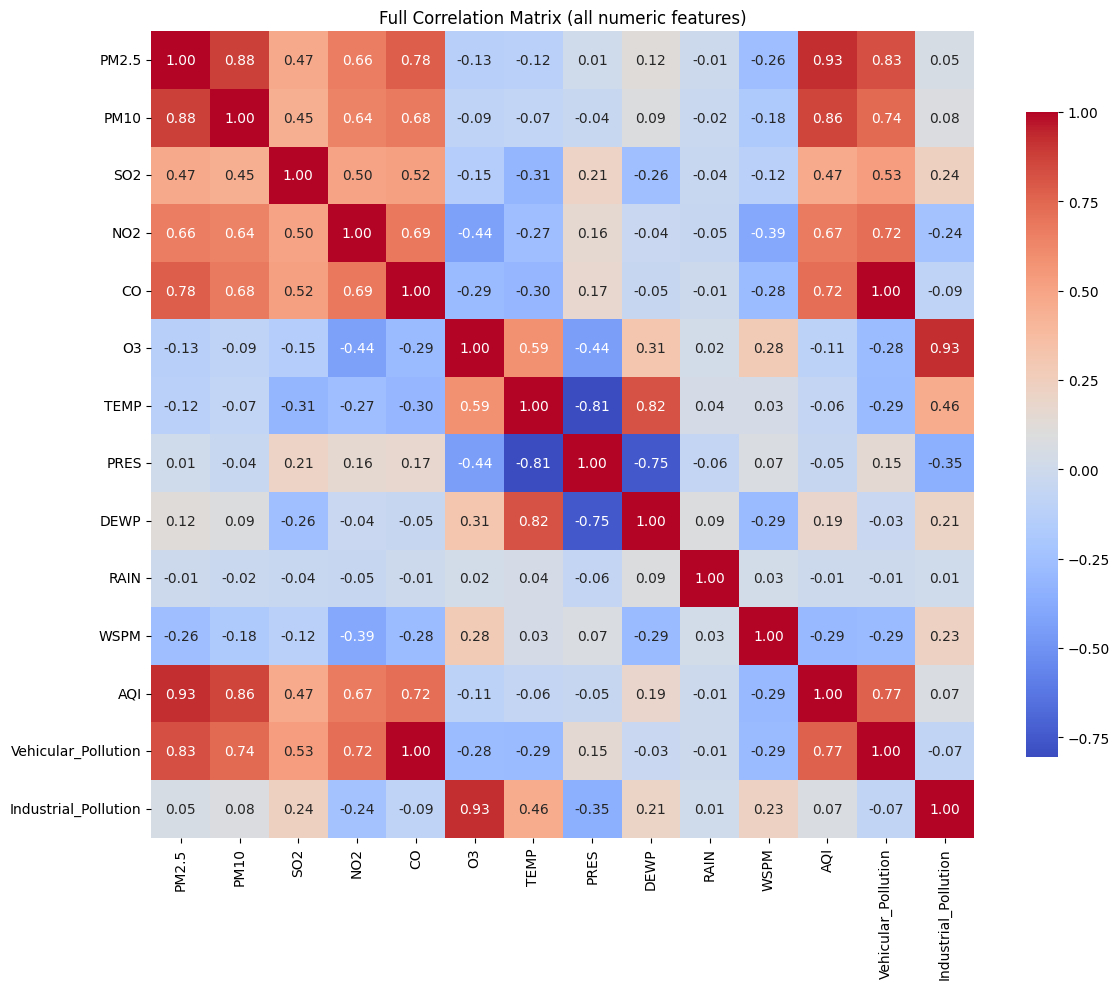

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the cleaned dataset
df = pd.read_csv(
    'merged_data_final.csv',
    parse_dates=['datetime'],
    index_col='datetime'
)

# 2.1 Build a mapping for wind-direction values
wd_unique = sorted(df['wd'].unique())
wd_map    = {wd: idx for idx, wd in enumerate(wd_unique)}
df['wd_code'] = df['wd'].map(wd_map)

# 2.2 Build a mapping for station names
station_unique = sorted(df['station'].unique())
station_map    = {st: idx for idx, st in enumerate(station_unique)}
df['station_code'] = df['station'].map(station_map)


# 3. Group pollutants into two categories
vehicular   = ['PM2.5', 'PM10', 'NO2', 'CO']
industrial  = ['SO2', 'O3']
df['Vehicular_Pollution']  = df[vehicular].mean(axis=1)
df['Industrial_Pollution'] = df[industrial].mean(axis=1)

# 4. Add a 'season' column
season_map = {
    12:'Winter', 1:'Winter', 2:'Winter',
    3:'Spring', 4:'Spring', 5:'Spring',
    6:'Summer', 7:'Summer', 8:'Summer',
    9:'Autumn',10:'Autumn',11:'Autumn'
}
df['season'] = df.index.month.map(season_map)

# 5. Compute time-based summaries (numeric only)
yearly   = df.resample('YE').mean(numeric_only=True)   # year-end
monthly  = df.resample('ME').mean(numeric_only=True)   # month-end
weekly   = df.resample('W').mean(numeric_only=True)
daily    = df.resample('D').mean(numeric_only=True)
seasonal = df.groupby('season').mean(numeric_only=True)

# 6. Compute correlation matrices
corr_pollutants   = df[['PM2.5','PM10','SO2','NO2','CO','O3','AQI']].corr()
corr_vehicle_ind  = df[['Vehicular_Pollution','Industrial_Pollution']].corr()

# 7. Save enriched DataFrame and summaries
df.to_csv('merged_data_eda.csv')
yearly.to_csv('yearly_summary.csv')
monthly.to_csv('monthly_summary.csv')
weekly.to_csv('weekly_summary.csv')
daily.to_csv('daily_summary.csv')
seasonal.to_csv('seasonal_summary.csv')

# 8. Display previews
print("=== Yearly Averages ===")
display(yearly.head())

print("\n=== Seasonal Averages ===")
display(seasonal)

print("\n=== Correlation: Pollutants & AQI ===")
display(corr_pollutants)

print("\n=== Correlation: Vehicular vs Industrial ===")
display(corr_vehicle_ind)

# 9. Full correlation matrix of all numeric features (excluding code cols)
numeric_cols = df.select_dtypes(include='number').columns.drop(['No','wd_code','station_code'])
corr_full = df[numeric_cols].corr()
corr_full.to_csv('full_correlation_matrix.csv')

plt.figure(figsize=(12,10))
sns.heatmap(
    corr_full,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'shrink': .8}
)
plt.title("Full Correlation Matrix (all numeric features)")
plt.tight_layout()
plt.show()


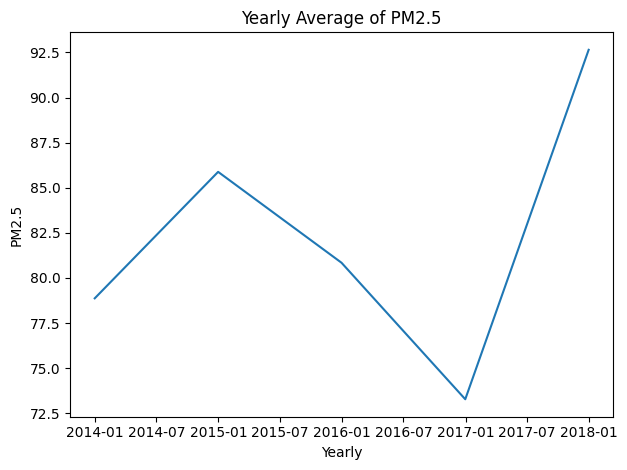

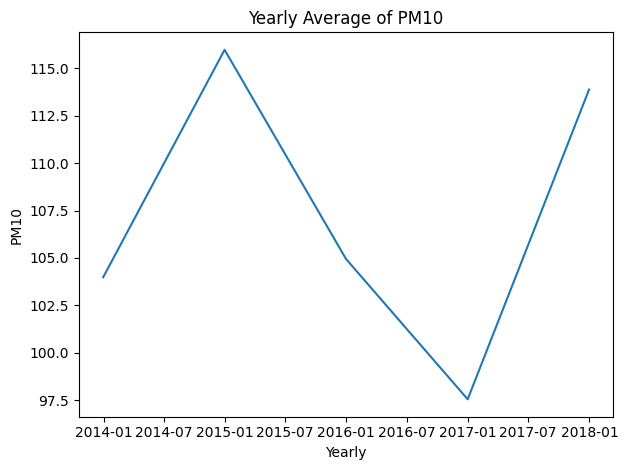

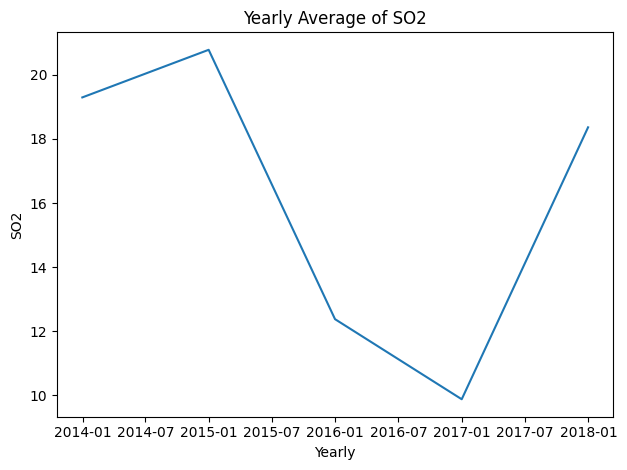

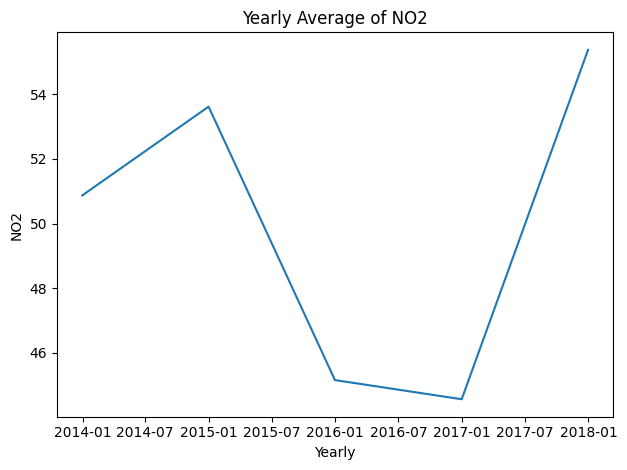

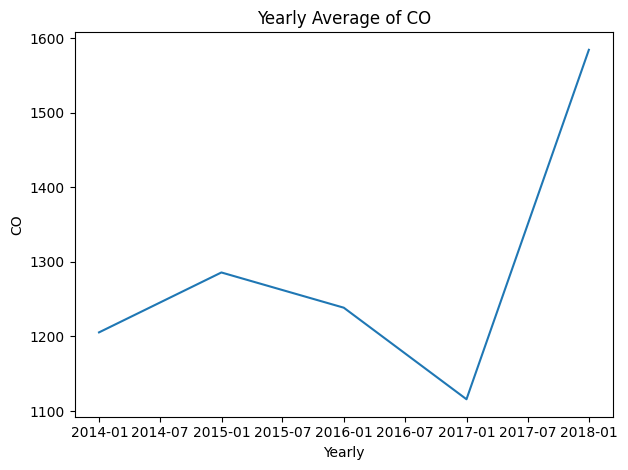

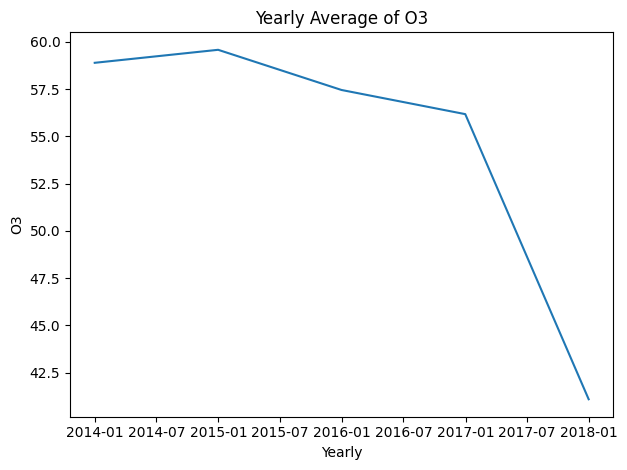

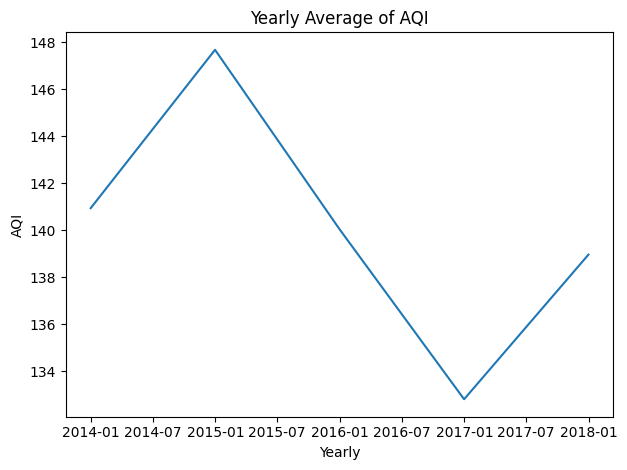

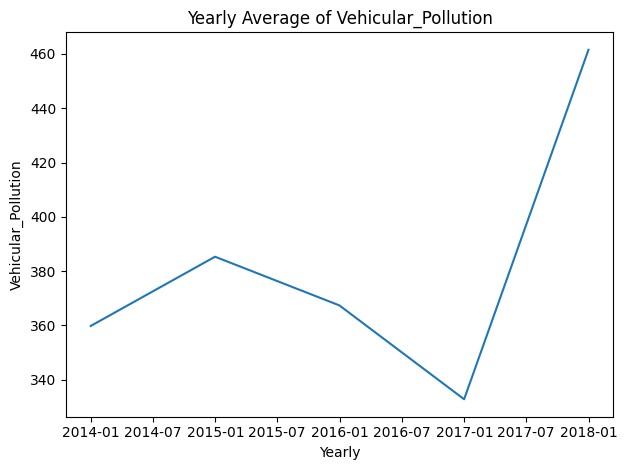

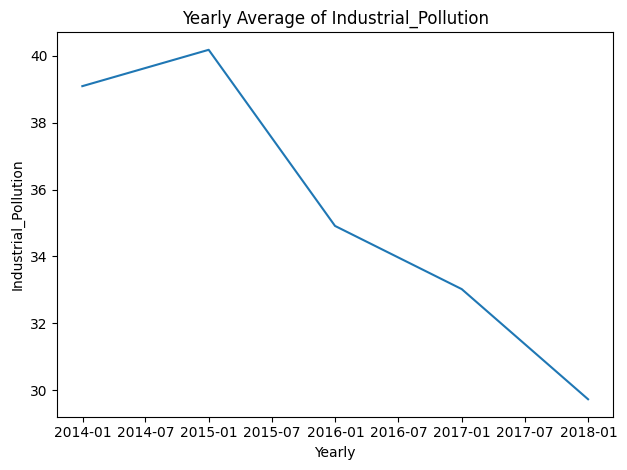

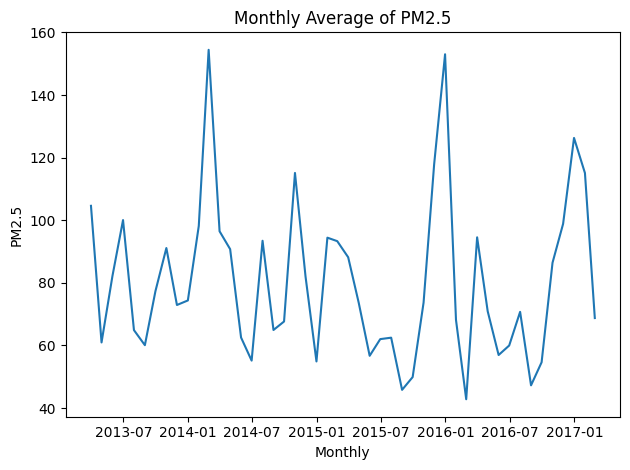

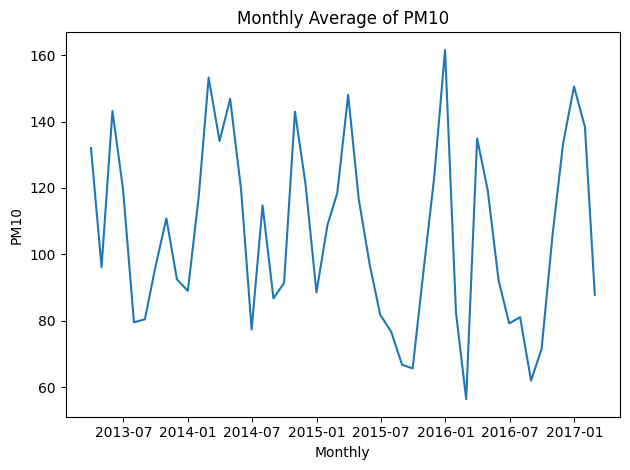

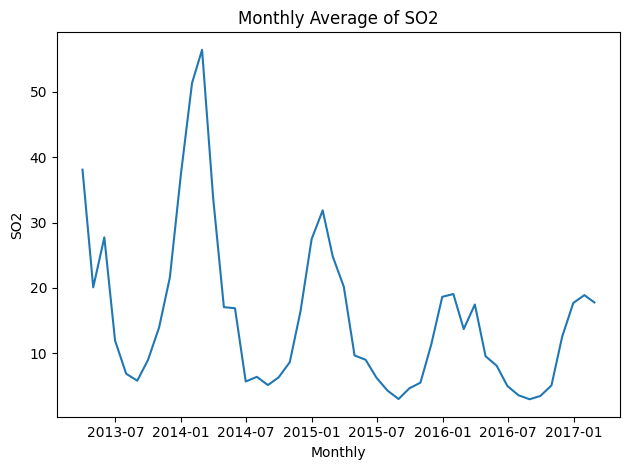

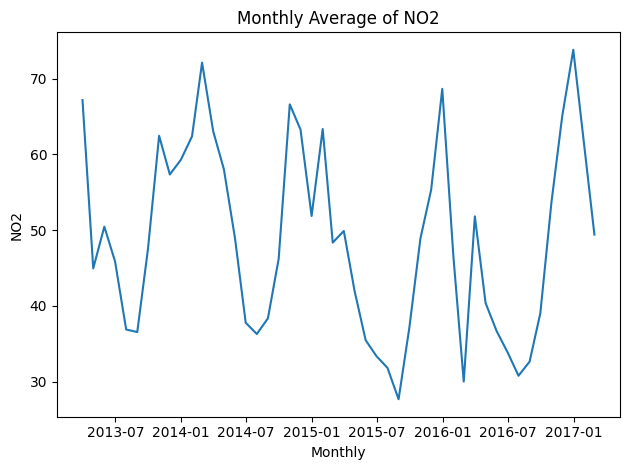

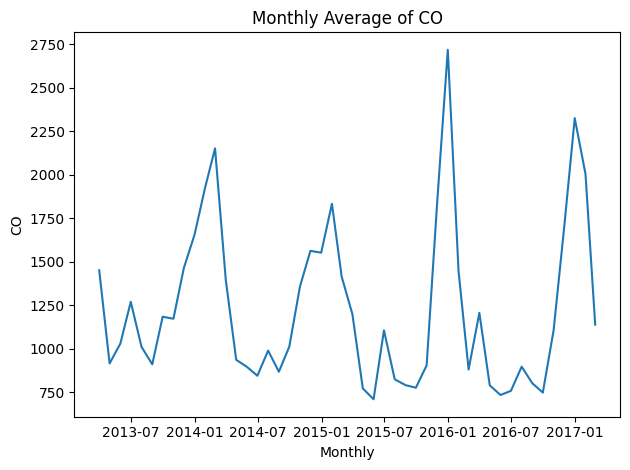

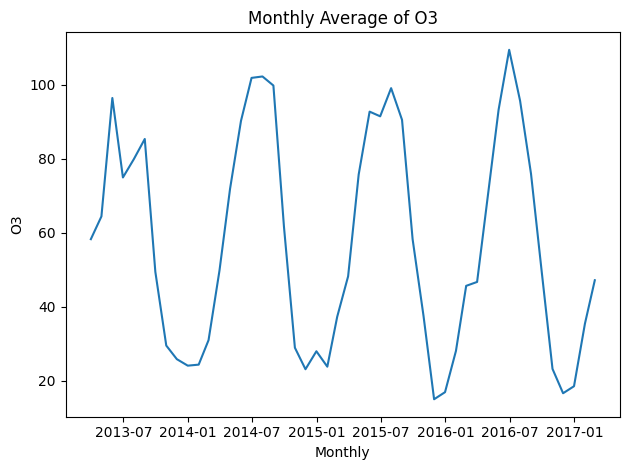

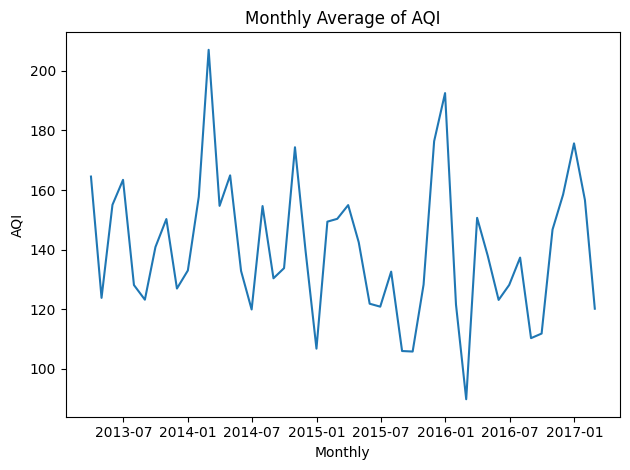

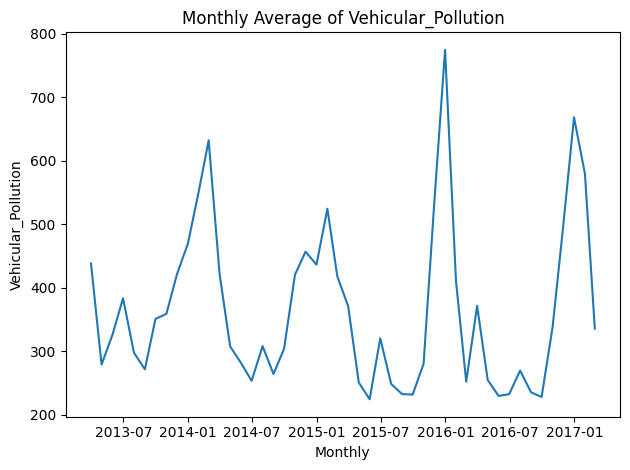

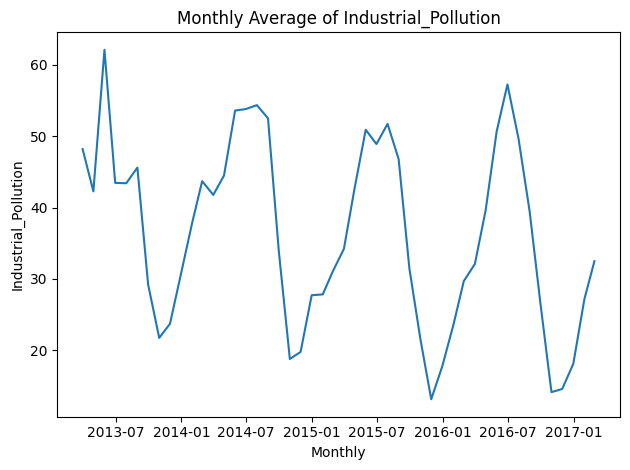

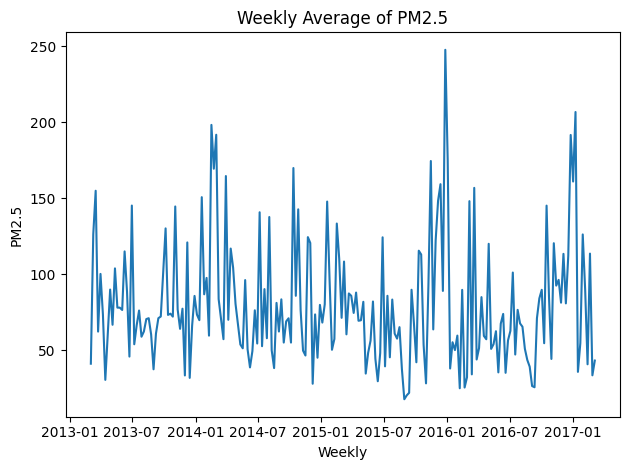

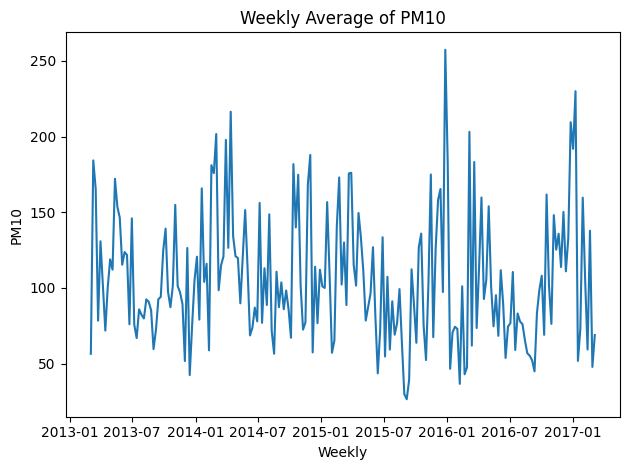

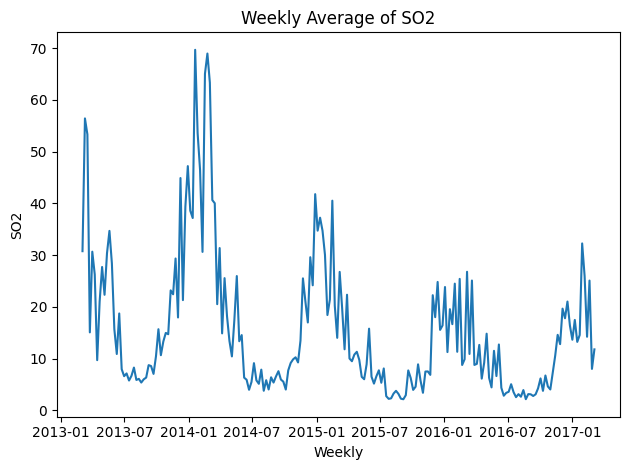

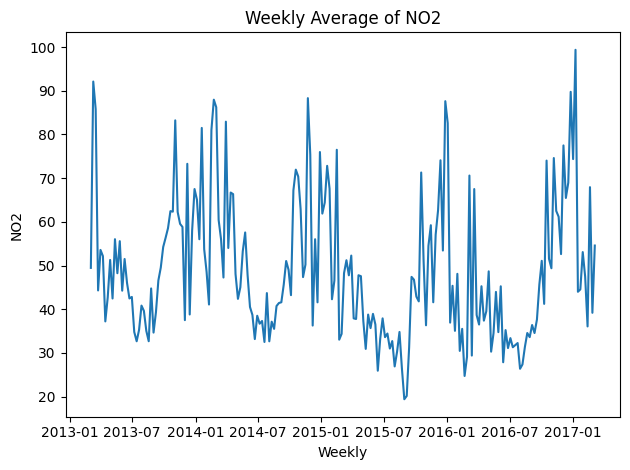

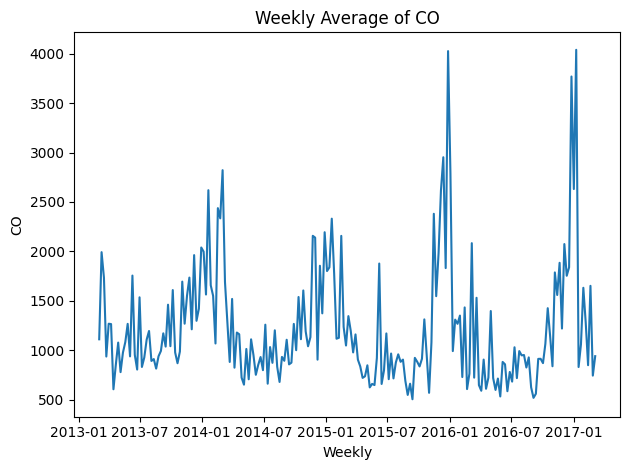

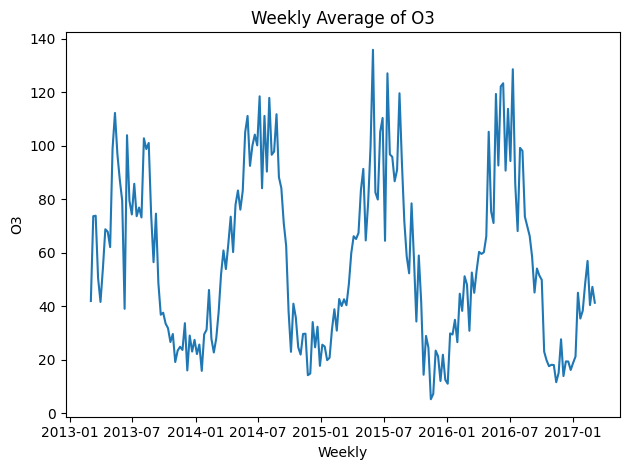

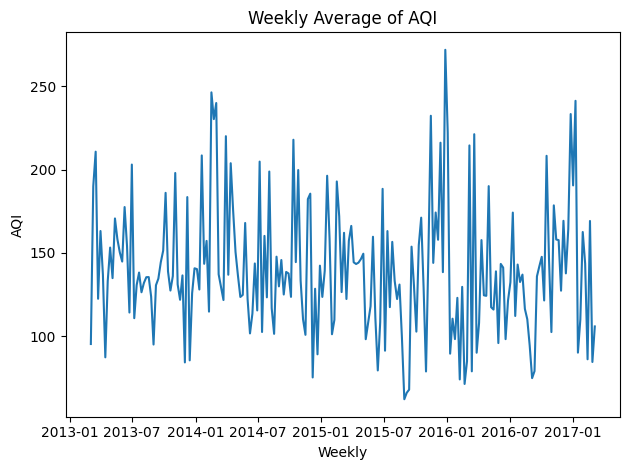

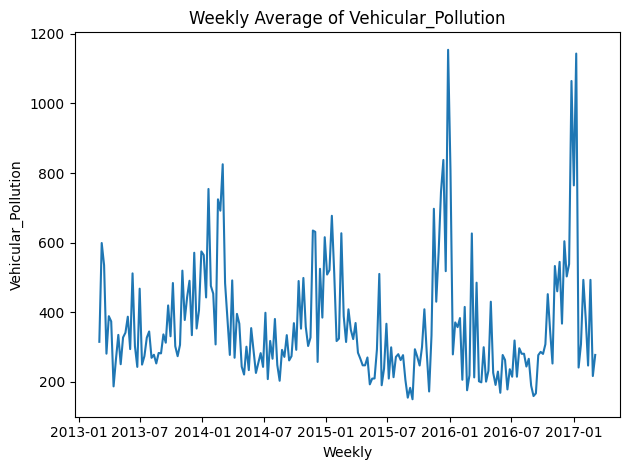

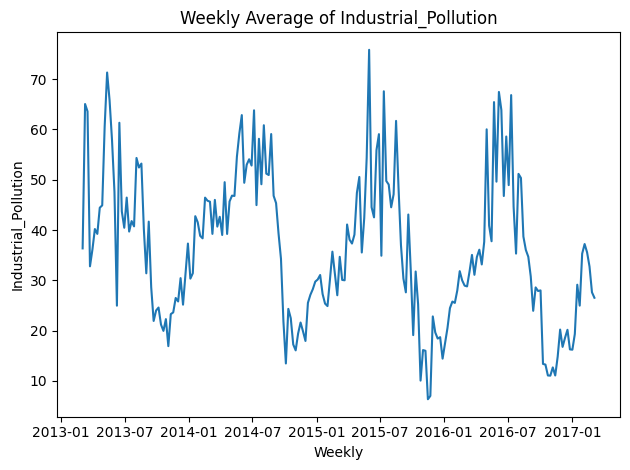

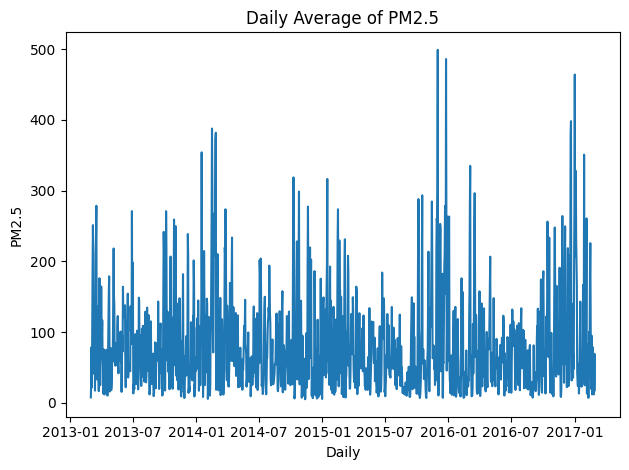

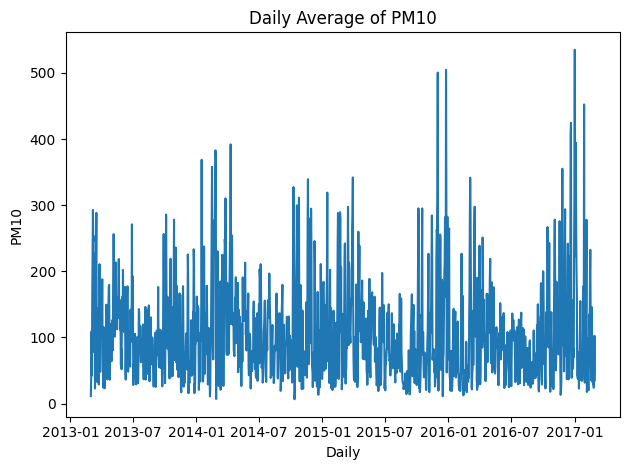

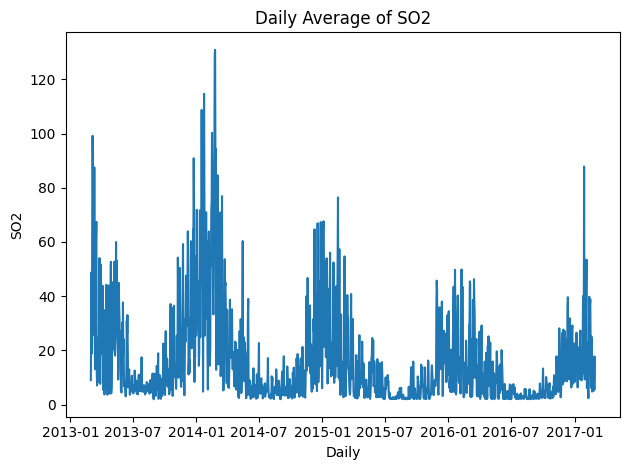

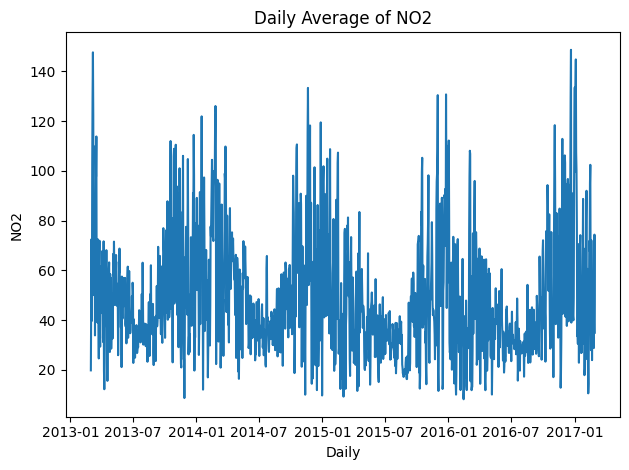

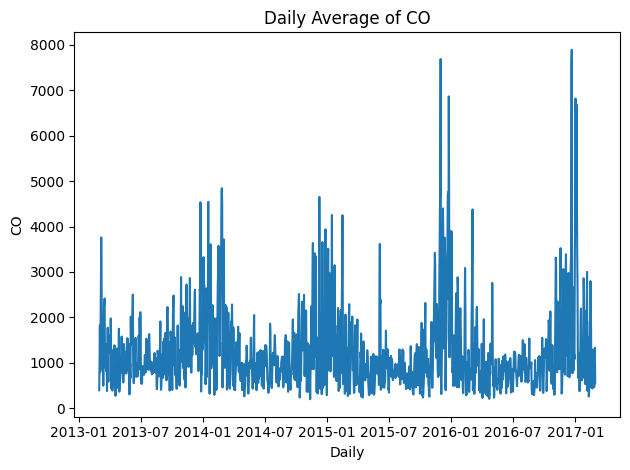

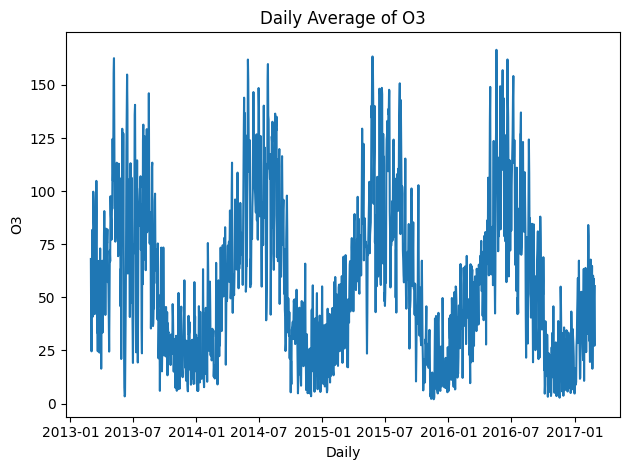

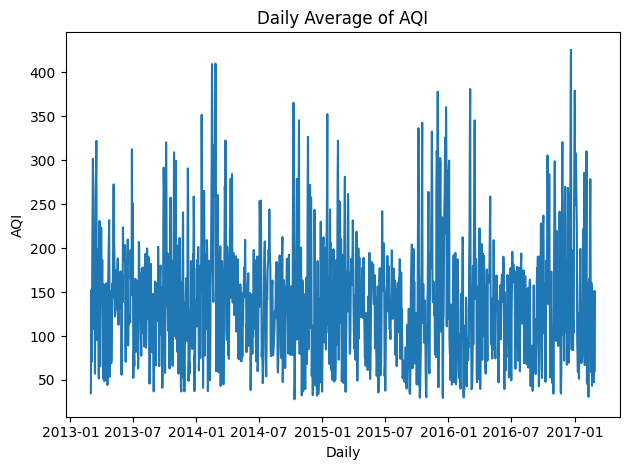

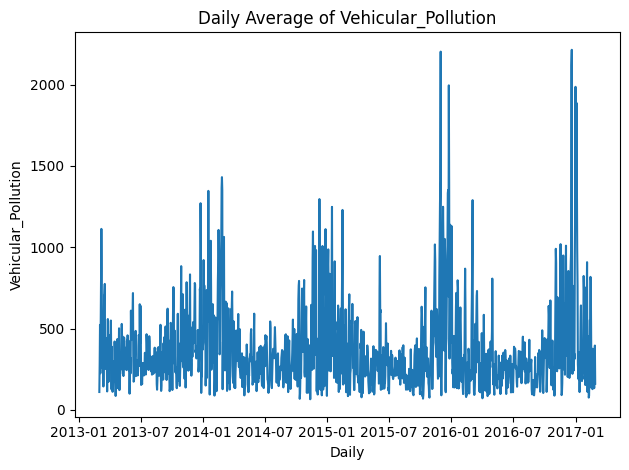

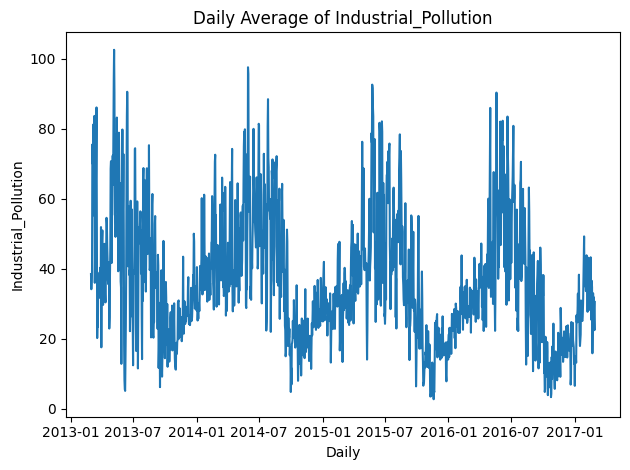

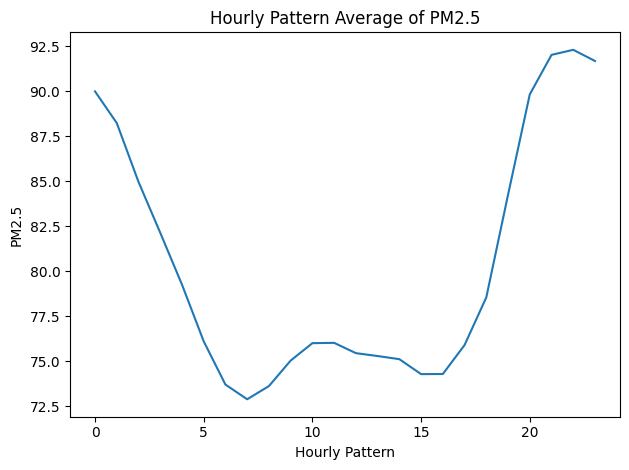

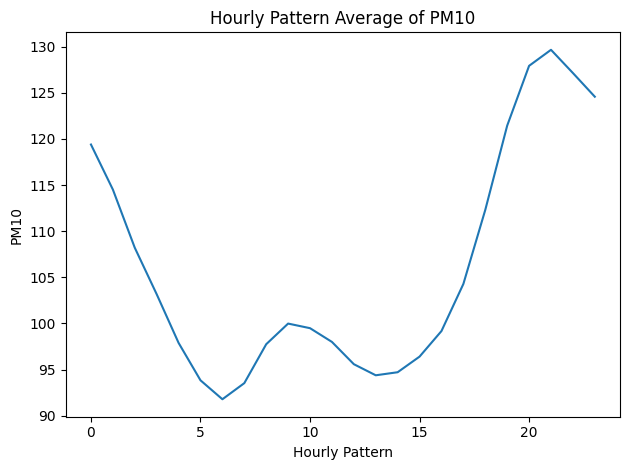

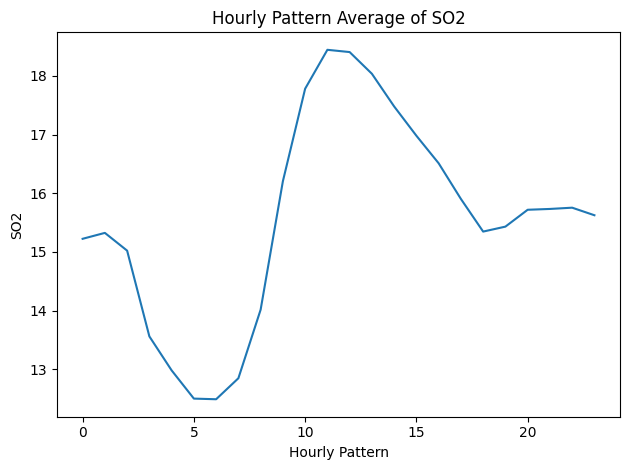

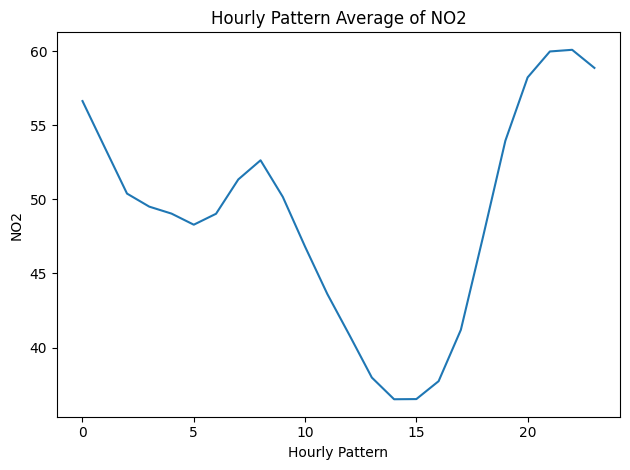

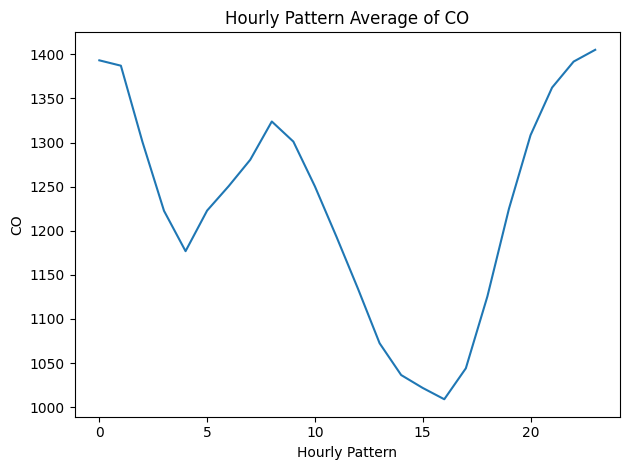

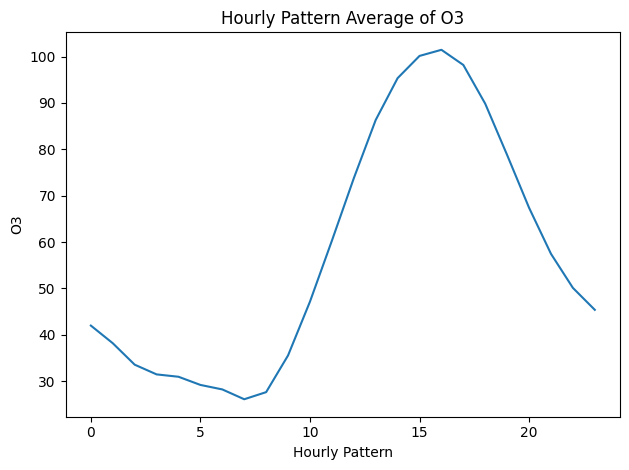

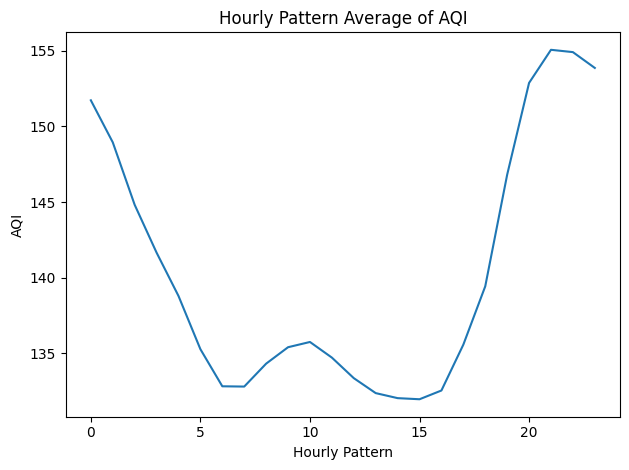

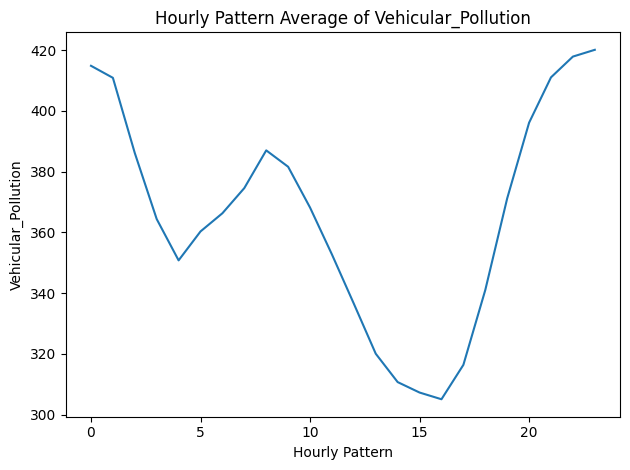

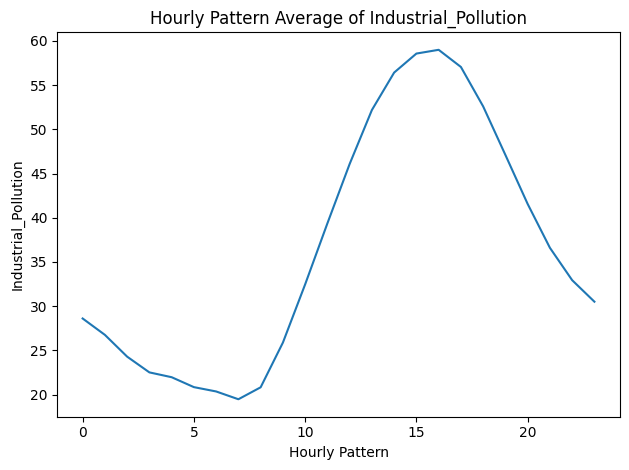

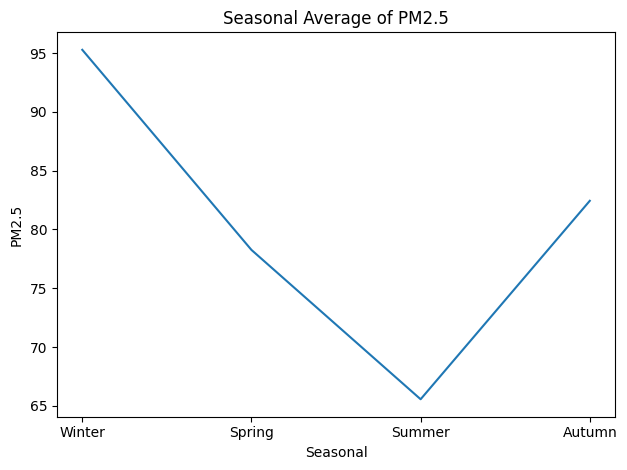

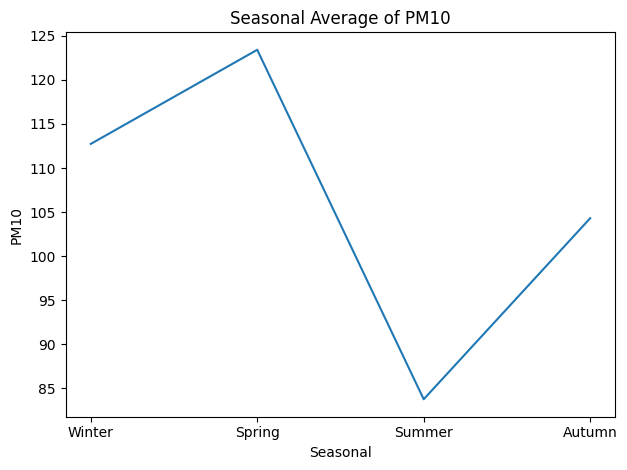

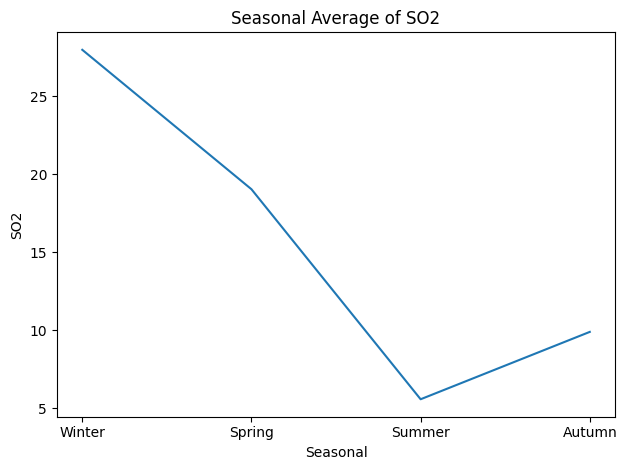

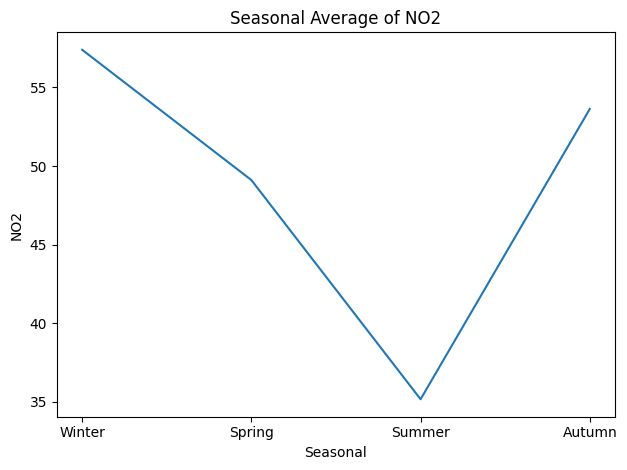

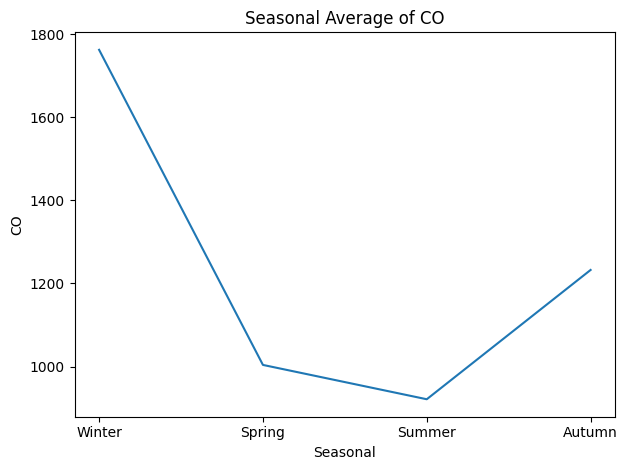

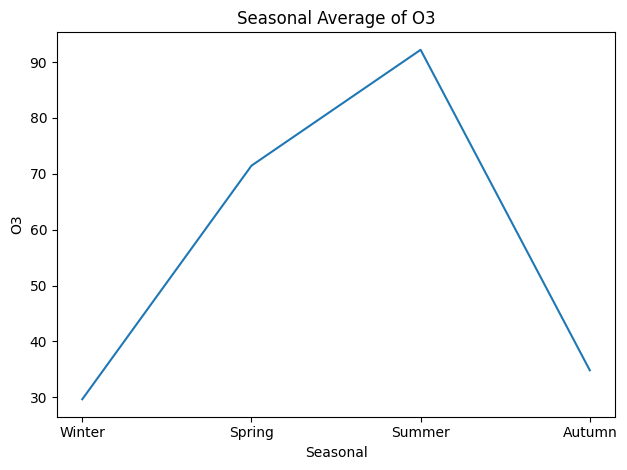

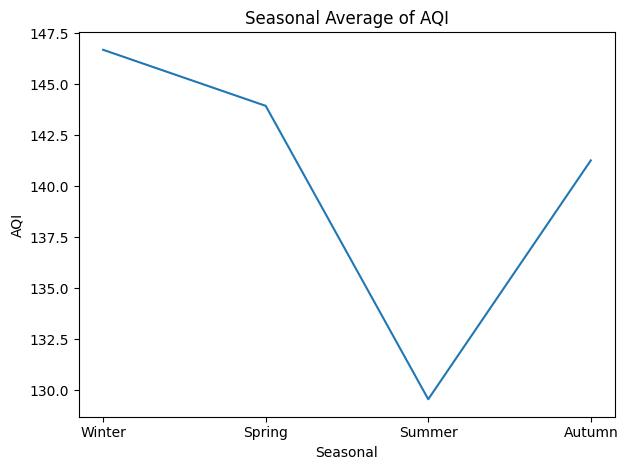

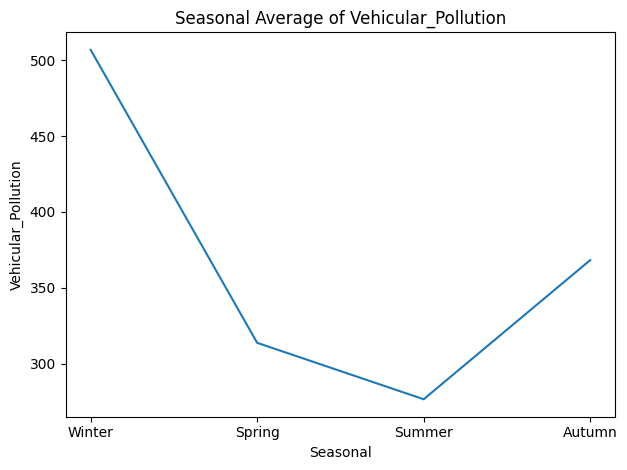

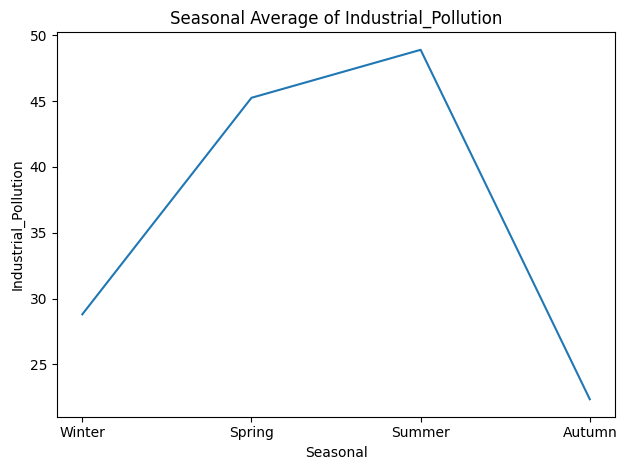

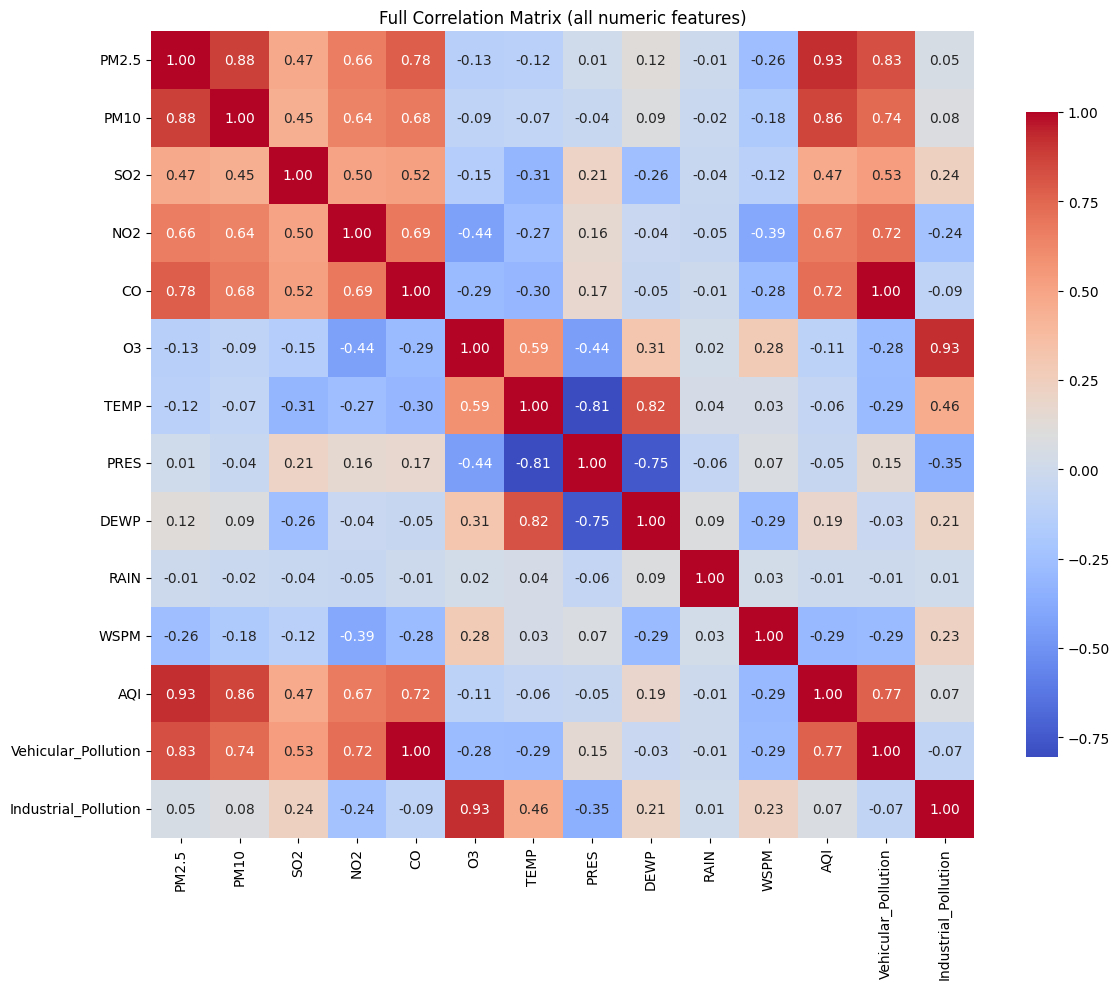

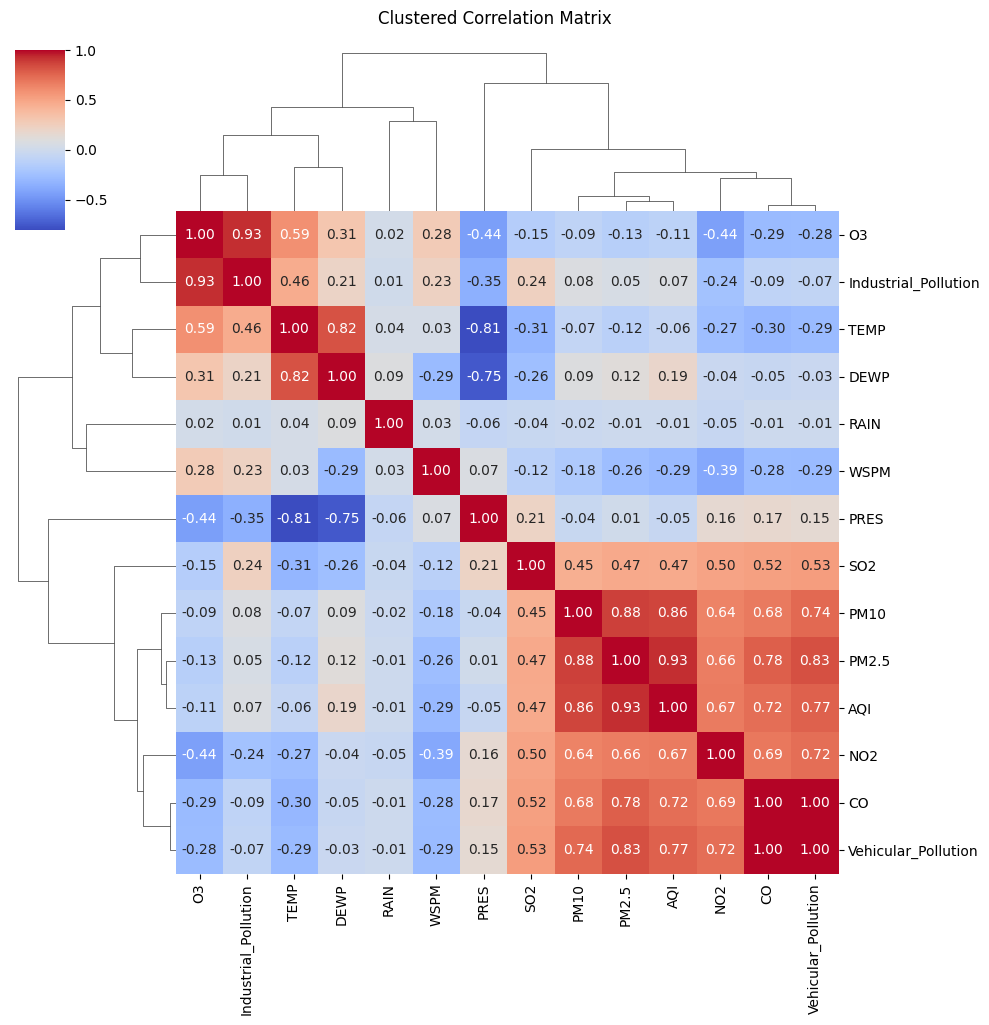

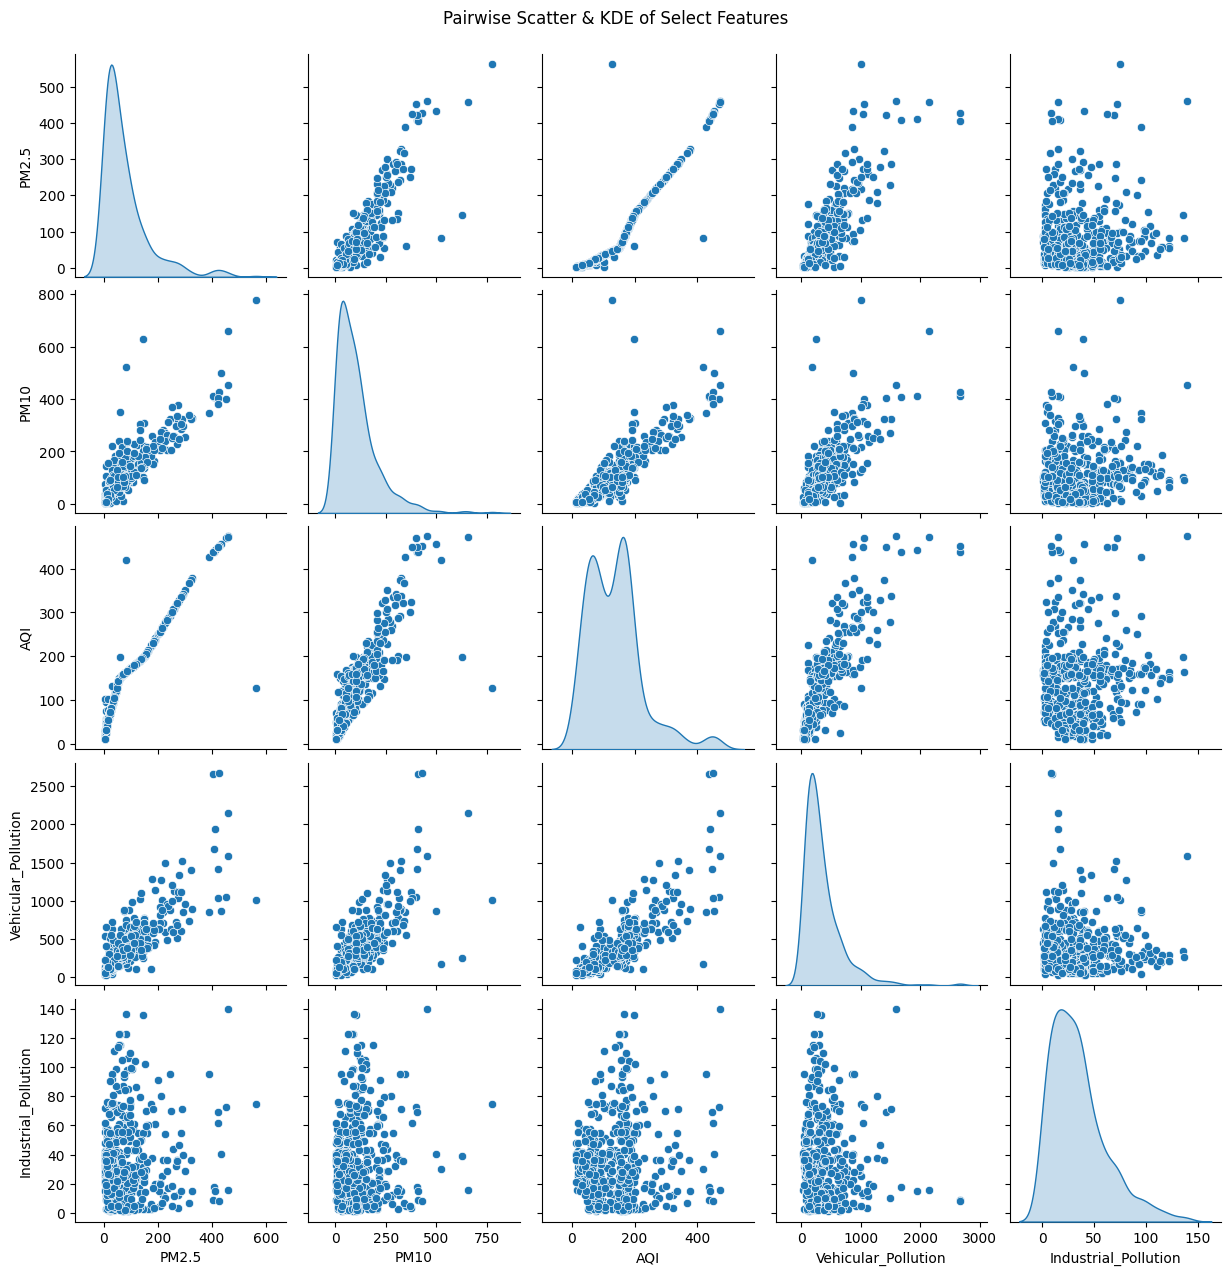

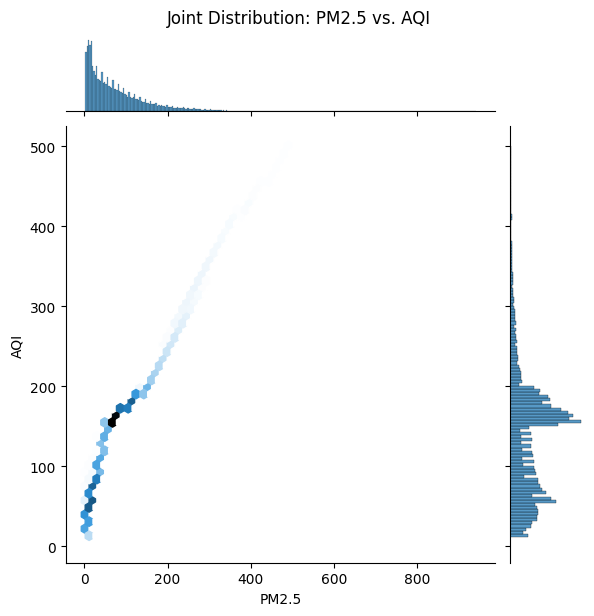

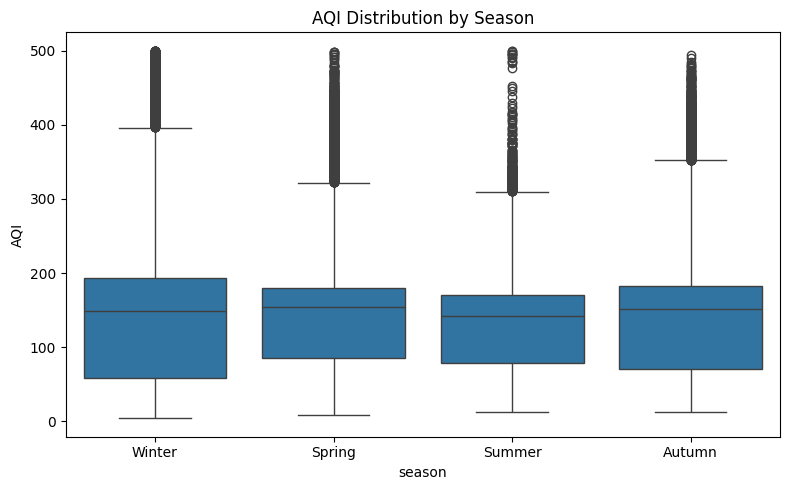

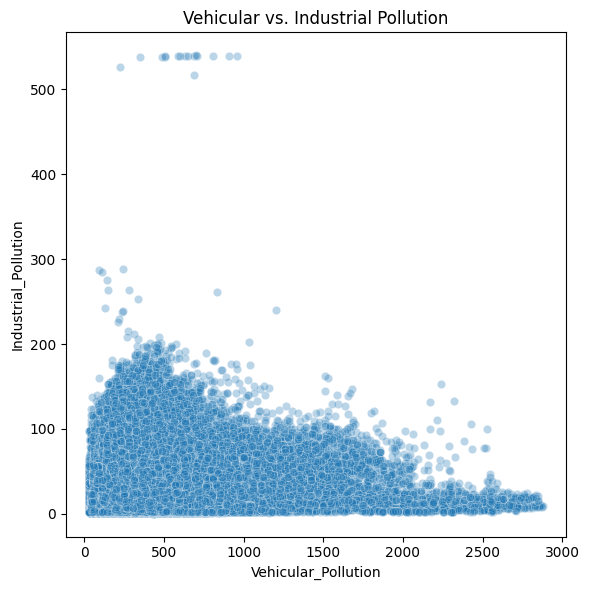

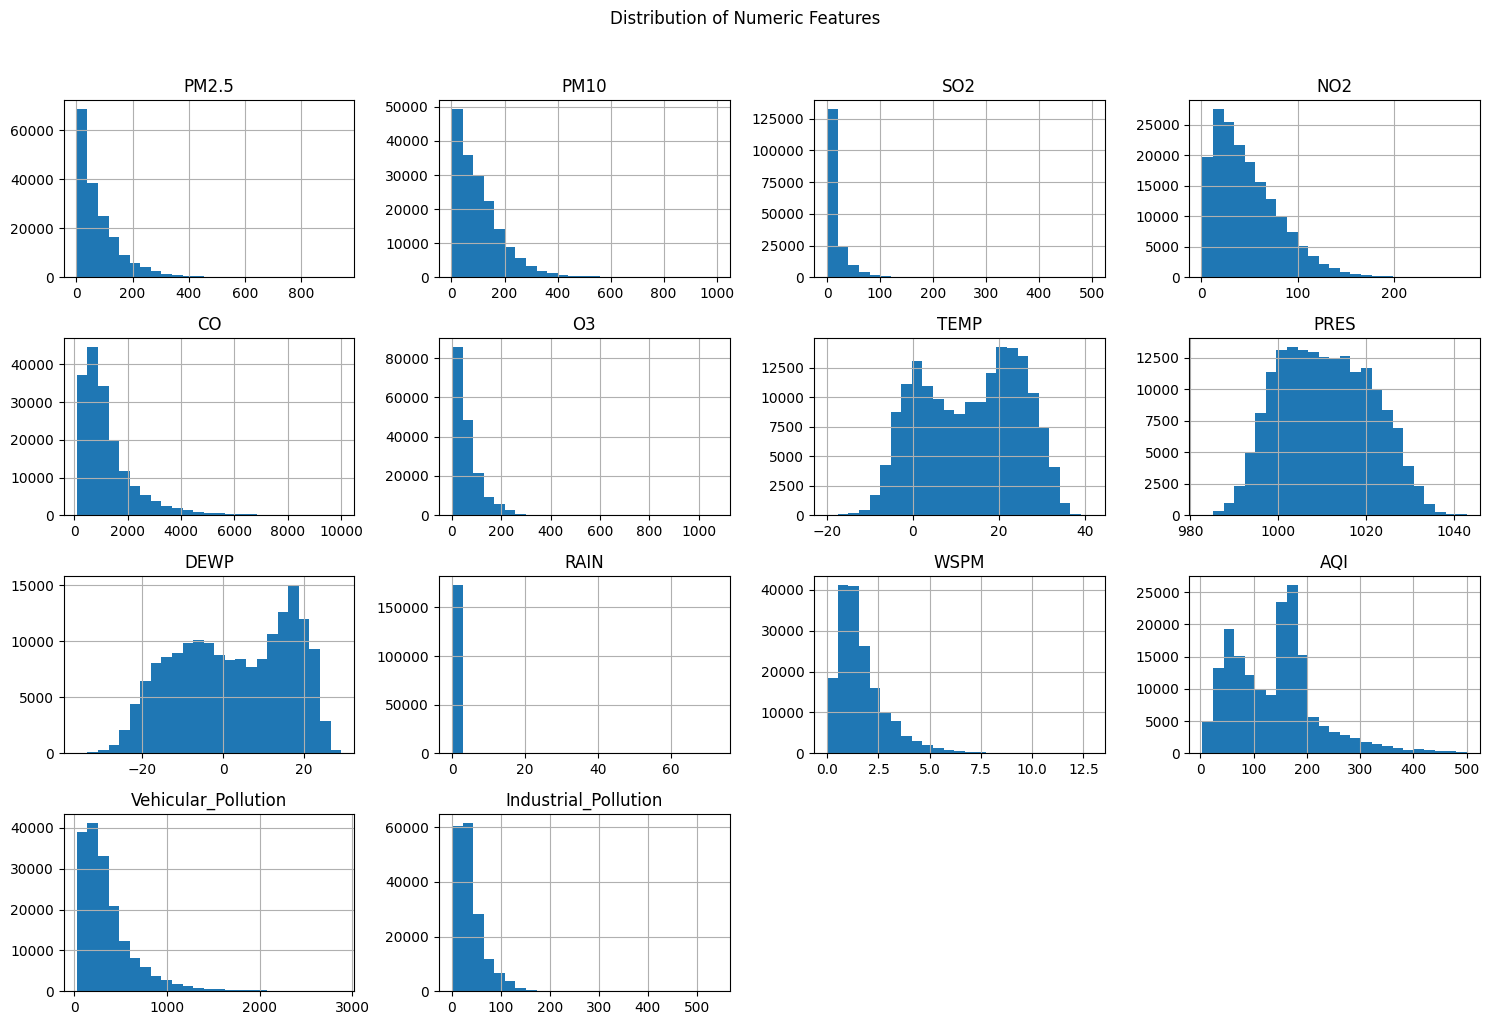

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the enriched dataset
df = pd.read_csv('merged_data_eda.csv', parse_dates=['datetime'], index_col='datetime')

# 2. Recompute numeric-only time summaries
yearly         = df.resample('YE').mean(numeric_only=True)
monthly        = df.resample('ME').mean(numeric_only=True)
weekly         = df.resample('W').mean(numeric_only=True)
daily          = df.resample('D').mean(numeric_only=True)
hourly_pattern = df.groupby(df.index.hour).mean(numeric_only=True)
seasonal       = df.groupby('season').mean(numeric_only=True).reindex(
                      ['Winter','Spring','Summer','Autumn']
                  )

# 3. Time‐series line plots for each pollutant, AQI, and grouped features
to_plot = [
    'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'AQI',
    'Vehicular_Pollution', 'Industrial_Pollution'
]
for label, grouping in [
    ('Yearly', yearly),
    ('Monthly', monthly),
    ('Weekly', weekly),
    ('Daily', daily),
    ('Hourly Pattern', hourly_pattern),
    ('Seasonal', seasonal)
]:
    for col in to_plot:
        plt.figure()
        plt.plot(grouping.index, grouping[col])
        plt.title(f'{label} Average of {col}')
        plt.xlabel(label)
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

# 4. Build and save full correlation matrix (excluding codes)
numeric_cols = df.select_dtypes(include='number').columns.drop(
    ['No','wd_code','station_code']
)
corr_full = df[numeric_cols].corr()
corr_full.to_csv('full_correlation_matrix.csv')

# 5. Heatmap of correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_full,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'shrink': .8}
)
plt.title("Full Correlation Matrix (all numeric features)")
plt.tight_layout()
plt.show()

# 6. Cluster map of correlation matrix
sns.clustermap(
    corr_full,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    figsize=(10,10)
)
plt.suptitle("Clustered Correlation Matrix", y=1.02)
plt.show()

# 7. Pairplot (sampled) for key relationships
sample = df[['PM2.5','PM10','AQI','Vehicular_Pollution','Industrial_Pollution']].sample(500, random_state=42)
sns.pairplot(sample, diag_kind='kde')
plt.suptitle("Pairwise Scatter & KDE of Select Features", y=1.02)
plt.show()

# 8. Joint plot for highest‐correlated pair (PM2.5 vs AQI)
sns.jointplot(
    x='PM2.5', y='AQI',
    data=df,
    kind='hex',
    height=6
)
plt.suptitle("Joint Distribution: PM2.5 vs. AQI", y=1.02)
plt.show()

# 9. Boxplot of AQI by season
plt.figure(figsize=(8,5))
sns.boxplot(
    x='season', y='AQI',
    data=df,
    order=['Winter','Spring','Summer','Autumn']
)
plt.title("AQI Distribution by Season")
plt.tight_layout()
plt.show()

# 10. Scatter of Vehicular vs Industrial Pollution
plt.figure(figsize=(6,6))
sns.scatterplot(
    x='Vehicular_Pollution',
    y='Industrial_Pollution',
    data=df,
    alpha=0.3
)
plt.title("Vehicular vs. Industrial Pollution")
plt.tight_layout()
plt.show()

# 11. Histograms of all numeric features
df[numeric_cols].hist(bins=25, figsize=(15,10))
plt.suptitle("Distribution of Numeric Features", y=1.02)
plt.tight_layout()
plt.show()
